# Facies Classification #

This project illustrates how to predict some facies from well log data. The dataset is the Volve Dataset (data from a North Sea oil field). 
In this Dataset there are many wells. In this notebook, we will work on well **F11-B**. For this well, we have two las files. 
One (WLC_PETRO_COMPUTED_INPUT_1.LAS) gives us some logs. In the other one (WLC_PETRO_COMPUTED_OUTPUT_1.LAS), we may find some simple classification by the usage of 3 flags ( **CARB_FLAG**, **COAL_FLAG**, **SAND_FLAG**). We are then able to create a classification with 4 tags : 
* Unknown(no flag assigned = 0 ), 
* Carbonate( carb_flag = 1), 
* Sand (Sand_flag = 2), 
* Coal (Coal_flag = 3) 

In this project, we are then:
1. Load, preprocess the data to have a clean dataframe
1. Explore the data set
1. Condition the dataset
1. Perform classification using NaiveBayes and Neural Network
1. control the quality of the classifier


## Step 1. Load and Display the Well-log Dataset ##

The next notebook cell gives you some useful functions to load and preprocess data to build facies description using a numeric scale.

In [1]:
import pandas as pd

def get_f11b_input():
    """
    return information for direct load of input las file as csv
    """
    filepath="./data/F11-B/WLC_PETRO_COMPUTED_INPUT_1.LAS"
    skiprows = 69
    headers = "Depth     ABDCQF01   ABDCQF02   ABDCQF03   ABDCQF04   BS         CALI       DRHO       GR         NPHI       PEF        RACEHM     RACELM     RD         RHOB       RM         ROP        RPCEHM     RPCELM     RT".strip() 
    strip_header =" ".join(headers.split())
    headers = strip_header.split(' ')

    return filepath, headers, skiprows 

def get_f11b_output():
    """
    return information for direct load of output las file as csv
    """
    filepath="./data/F11-B/WLC_PETRO_COMPUTED_OUTPUT_1.LAS"
    skiprows = 58
    headers = "Depth     BVW        CARB_FLAG  COAL_FLAG  KLOGH      PHIF       SAND_FLAG  SW         VSH"
    strip_header =" ".join(headers.split())
    headers = strip_header.split(' ')
    
    return filepath, headers, skiprows 

def load_las(filepath, skiprows, headers, d_low, d_up):
    """
    
    load a las file, with parameters retrieved from get_f11b_input and get_f11b_output method
    creates a pandas dataframe with Depth as index
    """
    df = pd.read_csv(filepath_or_buffer=filepath, sep='\s+', skiprows=skiprows,  na_values=-999.25, names=headers)
    df = df[(df['Depth']> d_low) & (df['Depth']<d_up)]
    return df.set_index('Depth')


def add_label(row):
    """
    creates a numeric scale for facies flags in output las dataframe
    """
    if row['CARB_FLAG'] > 0.0:
        return 1
    elif row['SAND_FLAG'] > 0.0:
        return 2
    elif row['COAL_FLAG'] > 0.0:
        return 3
    
    return 0


### 1.a create input dataframe

Idea is to build a dataframe restricted to a given depth range. $ depth \in [3351.7m, 4744.8m]$


In [2]:
import pandas as pd

d_low = 3351.7
d_up  = 4744.8


filepath="./data/F11-B/WLC_PETRO_COMPUTED_INPUT_1.LAS"
skiprows = 69

headers = "Depth  ABDCQF01   ABDCQF02   ABDCQF03   ABDCQF04   BS         CALI       DRHO       GR         NPHI       PEF  RACEHM     RACELM     RD         RHOB       RM         ROP        RPCEHM     RPCELM     RT".strip() 
strip_header =" ".join(headers.split())
headers = strip_header.split(' ')

df_input = pd.read_csv(filepath_or_buffer=filepath, sep='\s+', skiprows=skiprows,  na_values=-999.25, names=headers)
df_input = df_input[(df_input['Depth']> d_low) & (df_input['Depth']<d_up)]
df_input = df_input.set_index('Depth')

#filepath, headers, skiprows 
assert df_input.shape[0] == 13930
df_input.tail()


ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04   BS   CALI   DRHO      GR  \
Depth                                                                       
4744.3     2.461     2.458     2.440     2.439  8.5  8.641  0.081  16.249   
4744.4     2.456     2.458     2.438     2.443  8.5  8.672  0.077  18.881   
4744.5     2.449     2.451     2.431     2.443  8.5  8.672  0.070  20.047   
4744.6     2.440     2.440     2.433     2.440  8.5  8.671  0.064  22.520   
4744.7     2.427     2.431     2.450     2.442  8.5  8.568  0.059  25.265   

         NPHI    PEF  RACEHM  RACELM     RD   RHOB     RM     ROP  RPCEHM  \
Depth                                                                       
4744.3  0.115  4.329   1.384   1.693  1.550  2.447  1.809  17.408   1.809   
4744.4  0.118  4.271   1.350   1.728  1.473  2.446  1.487  17.475   1.487   
4744.5  0.121  4.162   1.507   1.782  1.366  2.441  1.208  17.546   1.208   
4744.6  0.120  4.087   1.660   1.802  1.358  2.438  1.137  18.464   1.137   
4744.7  0.125  4.136   1.765   1.817  1.417  2.440  1.093  19.383   1.093   

        RPCELM     RT  
Depth                  
4744.3   1.550  1.809  
4744.4   1.473  1.487  
4744.5   1.366  1.208  
4744.6   1.358  1.137  
4744.7   1.417  1.093

### 1.b create output dataframe

In [3]:
filepath="./data/F11-B/WLC_PETRO_COMPUTED_OUTPUT_1.LAS"
skiprows = 58
headers = "Depth     BVW        CARB_FLAG  COAL_FLAG  KLOGH      PHIF       SAND_FLAG  SW         VSH"
strip_header =" ".join(headers.split())
headers = strip_header.split(' ')

df_output = pd.read_csv(filepath_or_buffer=filepath, sep='\s+', skiprows=skiprows,  na_values=-999.25, names=headers)
df_output = df_output[(df_output['Depth']> d_low) & (df_output['Depth']<d_up)]
df_output = df_output.set_index('Depth')
# or simple way use the function 
#filepath, headers, skiprows  = get_f11b_output()

assert df_output.shape[0] == 13930
df_output.tail()

BVW  CARB_FLAG  COAL_FLAG  KLOGH   PHIF  SAND_FLAG     SW    VSH
Depth                                                                     
4744.3  0.094        0.0        0.0  6.093  0.125        1.0  0.747  0.112
4744.4  0.102        0.0        0.0  6.180  0.127        1.0  0.801  0.139
4744.5  0.111        0.0        0.0  7.216  0.130        1.0  0.856  0.150
4744.6  0.114        0.0        0.0  6.819  0.131        1.0  0.874  0.175
4744.7  0.116        0.0        0.0  6.465  0.132        1.0  0.884  0.203

## 1.c merge input/output dataframe

Here we have to: 
1. build an unique dataframe **df_all** that merge the two previous ones **df_input** and **df_output** against **Depth** index. (__hint__: inner join).
1. append a new column named **label** that use numerical scale define in **add_label** function and remove the useless column for each flag
1. modify **RT** column to have log10 values instead of the ones stored in las file
1. modify dataframe so that 'Depth' become a column not an index anymore (__hint__: reset_index method)
1. drop all rows where at least on NaN exists in any column.


At the end, **df_all** dataframe has 13930 rows and 8 columns

In [4]:

flags = ['CARB_FLAG', 'SAND_FLAG', 'COAL_FLAG']
df_all = df_input.join(df_output, how='inner', on='Depth')
df_all
#df_all = df_all.drop(flags, axis =1)
#df_all = df_all.drop(flags, axis =1)
df_all['CARB_FLAG']

Depth
3351.8    0.0
3351.9    0.0
3352.0    0.0
3352.1    0.0
3352.2    0.0
         ... 
4744.3    0.0
4744.4    0.0
4744.5    0.0
4744.6    0.0
4744.7    0.0
Name: CARB_FLAG, Length: 13930, dtype: float64

In [5]:
import numpy as np
import matplotlib.colors as colors

#Global variable for used feature in classification
features = ['NPHI', 'RHOB','GR', 'RT', 'PEF', 'CALI']



#Global variables used for facies class definition
flags = ['CARB_FLAG', 'SAND_FLAG', 'COAL_FLAG']
facies_cls = ['Unknown', 'Carb', 'Sand', 'Coal']
facies_colors = ['#FFFFFF', '#F4D03F','#AED6F1','#6E2C00' ]
cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')


df_all = pd.concat([df_input[features], df_output[flags]], axis=1, join= 'inner')
## Construct df_all with all constraints given above


# add the label column 
df_all['label'] = df_all.apply(lambda row: add_label(row), axis=1)

# drop all the column in flags
df_all = df_all.drop(flags, axis =1)

# compute the log10 of RT column
from math import log10
df_all['RT'] = [log10(i) for i in df_all['RT']]

# reset the index Depth as column
df_all = df_all.reset_index()


df_all.shape
#drop nan values
df_all.dropna(how='any', axis = 0)
##  Test to be sure code is correct
assert df_all.shape[0] == 13930
assert df_all.shape[1] == 8
last_row = [4744.7, 0.125, 2.440, 25.265, 0.038620, 4.136, 8.568, 2]
#comparison = (last_row - df_all.iloc[13929, :].values) < 1e-9
#assert comparison.all()


df_all.tail()

Depth   NPHI   RHOB      GR        RT    PEF   CALI  label
13925  4744.3  0.115  2.447  16.249  0.257439  4.329  8.641      2
13926  4744.4  0.118  2.446  18.881  0.172311  4.271  8.672      2
13927  4744.5  0.121  2.441  20.047  0.082067  4.162  8.672      2
13928  4744.6  0.120  2.438  22.520  0.055760  4.087  8.671      2
13929  4744.7  0.125  2.440  25.265  0.038620  4.136  8.568      2

In [6]:
df_all['label']

0        0
1        0
2        0
3        0
4        0
        ..
13925    2
13926    2
13927    2
13928    2
13929    2
Name: label, Length: 13930, dtype: int64

In [23]:
# check if NaNs still exists
df_all.isnull().sum()

Depth    0
NPHI     0
RHOB     0
GR       0
RT       0
PEF      0
CALI     0
label    0
dtype: int64

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_facies_col(facies, ax_facies):
    cluster=np.repeat(np.expand_dims(facies.values,1), 100, 1)
    im=ax_facies.imshow(cluster, interpolation='none', aspect='auto',
                cmap=cmap_facies,vmin=0, vmax=4)

    divider = make_axes_locatable(ax_facies)
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    ratio = int(12*80/20)
    cbar.set_label((ratio*' ').join(facies_cls))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    ax_facies.set_yticklabels([])

def draw_logs(df, logs=['GR'], key='Depth', label_col=None):
    """
    draw logs of dataframe as a function of key column ('Depth' by default)
    logs define what logs are we going to us (ex: logs = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF'])
    label_col is not No
    """
    df_plot = df.sort_values(by=key)
    ztop=df_plot[key].min(); zbot=df_plot[key].max()

    # create the subplots; ncols equals the number of logs
    n_cols = len(logs)
    if label_col is not None:
        n_cols += 1
    fig, ax = plt.subplots(nrows=1, ncols=n_cols, figsize=(8, 12), squeeze=False)

    # looping each log to display in the subplots

    colors = ['black', 'red', 'blue', 'green', 'purple', 'black', 'orange']

    for i in range(len(logs)):
        if i != 0:
            ax[0, i].set_yticklabels([])
        ax[0, i].set_ylim(ztop,zbot)
        ax[0, i].invert_yaxis()
        ax[0, i].plot(df_plot[logs[i]], df_plot[key], color=colors[i])
        ax[0, i].set_title(logs[i])
        ax[0, i].grid(True)
        
    if label_col is not None:
        draw_facies_col(df[label_col], ax[0, n_cols-1])

    plt.show()
  

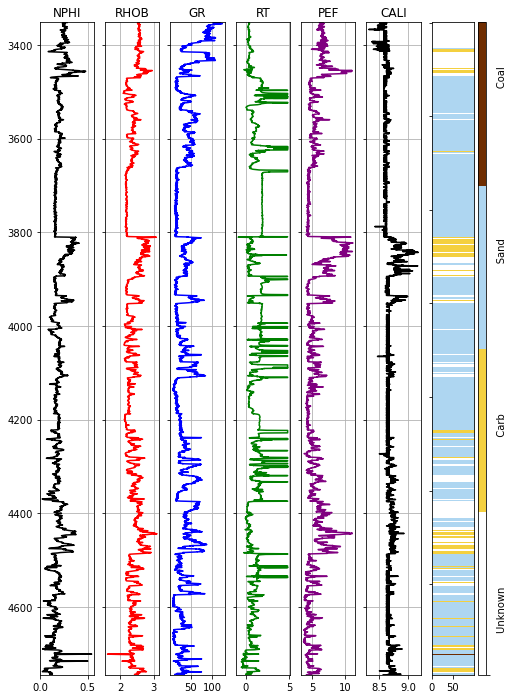

In [25]:
draw_logs(df_all, features,  label_col='label') # label_col='label'

## 2 Explore the data ##

### 2.a representativeness of data ### 
we can look at how the various facies are represented by the entire training set.

Give and test at least 3 methods to compute the number of sample that we have for each facies.

__hint__ use `value_counts` , `groupby` and `pivot_table` methods

In [9]:
facies_count = df_output[flags].value_counts()

facies_count

CARB_FLAG  SAND_FLAG  COAL_FLAG
0.0        1.0        0.0          9688
           0.0        0.0          2953
1.0        0.0        0.0          1268
0.0        0.0        1.0            21
dtype: int64

In [10]:
# the question on which column are going to groupby 
facies_groupby = df_output[flags].groupby('COAL_FLAG').sum()
df_output
facies_groupby

CARB_FLAG  SAND_FLAG
COAL_FLAG                      
0.0           1268.0     9688.0
1.0              0.0        0.0

In [11]:
## pivot_table index is label, use RT as value and np.count_nonzero or len as aggregate function
import numpy as np
facies_pivot = df_all.pivot_table(index = 'label', values = 'RT', aggfunc= np.count_nonzero) # aggfunc= len


facies_pivot


RT
label           
0.000000  2953.0
0.333333  1267.0
0.666667  9688.0
1.000000    21.0

In [12]:
df_all

Depth      NPHI      RHOB        GR        RT       PEF      CALI  \
0      0.000000  0.504836  0.637047  0.852370  0.215516  0.386837  0.358226   
1      0.000072  0.495164  0.634997  0.857328  0.213696  0.371934  0.303384   
2      0.000144  0.470019  0.632946  0.847290  0.215516  0.363097  0.330222   
3      0.000215  0.454545  0.631579  0.853238  0.218167  0.356107  0.303384   
4      0.000287  0.441006  0.630212  0.845684  0.219126  0.346874  0.303384   
...         ...       ...       ...       ...       ...       ...       ...   
13925  0.999713  0.176015  0.560492  0.069925  0.196751  0.089950  0.376896   
13926  0.999785  0.181818  0.559809  0.092779  0.181680  0.082300  0.413069   
13927  0.999856  0.187621  0.556391  0.102904  0.165703  0.067924  0.413069   
13928  0.999928  0.185687  0.554340  0.124377  0.161045  0.058032  0.411902   
13929  1.000000  0.195358  0.555707  0.148212  0.158011  0.064495  0.291715   

          label  
0      0.000000  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.000000  
...         ...  
13925  0.666667  
13926  0.666667  
13927  0.666667  
13928  0.666667  
13929  0.666667  

[13930 rows x 8 columns]

### 2.b Analyze correlation between features ###

Compute and display matrix of correlation between features: __hint__ use **corrcoef** form numpy

0 NPHI
1 RHOB
2 GR
3 RT
4 PEF
5 CALI


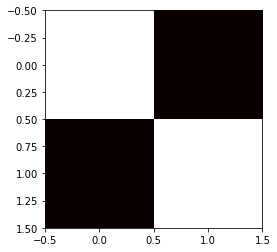

In [30]:
cormat = np.corrcoef(df_all['GR'],df_all['RT'])

for i in range(len(df_all[features].columns)):
    print("%d %s" % (i , df_all[features].columns[i]))
plt.imshow(cormat, cmap='hot')

Are NPHI, RHOB, GR correlated ? Is RT correlated with other features ?

### 2.c Crossplots ###
Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type. This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset. We can employ the very useful **Seaborn** library to quickly create a nice looking scatter matrix. __hint__ use **pairplot** of seaborn.

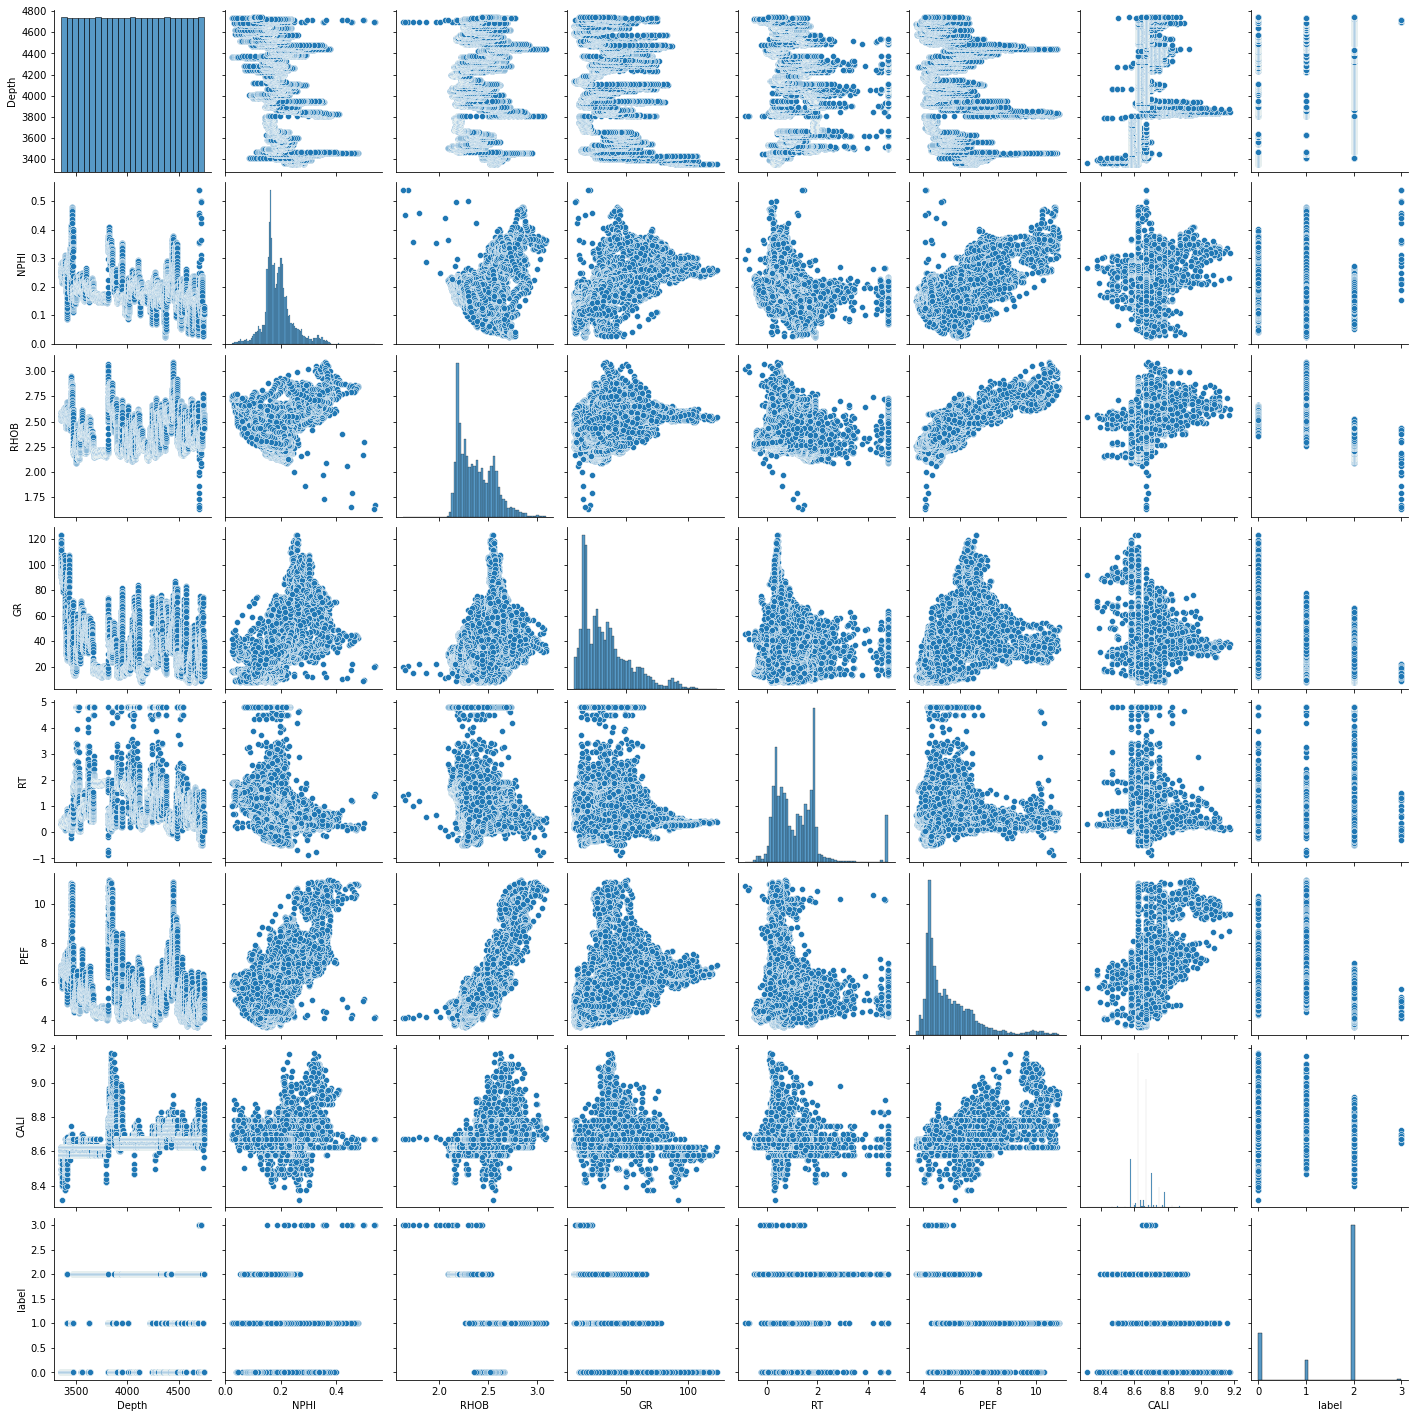

In [15]:
import seaborn as sns
sns.pairplot(df_all)

## 3 Conditioning of the data set

### 3.a Scale the data
All features don't use the same range for their values.

**Scikit** includes a **preprocessing** module that can 'standardize' the data. Morover, some classifiers assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).

Try some of the Scaler proposed by scikit:
* MinMaxScaler
* RobustScaler
* StandardScaler

At each time, then draw the logs, look at the current x axis for each feature and in the cross plot look at the histogram of each feature. Look if they seem gaussian ! 

In [7]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

## Your Code Here
# create a dataframe df_normalized that is a scaled version of df_all
df_all[['CALI', 'Depth', 'GR', 'NPHI', 'PEF', 'RHOB', 'RT', 'label']] = MinMaxScaler().fit_transform(df_all[['CALI', 'Depth', 'GR', 'NPHI', 'PEF', 'RHOB', 'RT', 'label']])
df_normalized = df_all[['CALI', 'Depth', 'GR', 'NPHI', 'PEF', 'RHOB', 'RT', 'label']] 


## Test your code is correct
# df_normalize should be a dataframe of 13930 rows with 8 columns
assert df_normalized.shape[0] == 13930
assert df_normalized.shape[1] == 8
# check that all columns are in the data set
expected_columns = ['CALI', 'Depth', 'GR', 'NPHI', 'PEF', 'RHOB', 'RT', 'label']
df_columns = sorted(df_normalized.columns.values)
assert df_columns == expected_columns





In [ ]:
draw_logs(df_normalized, features, label_col='label')

Draw crossplot again using label as **hue** parameter and **facies_colors** as palette.

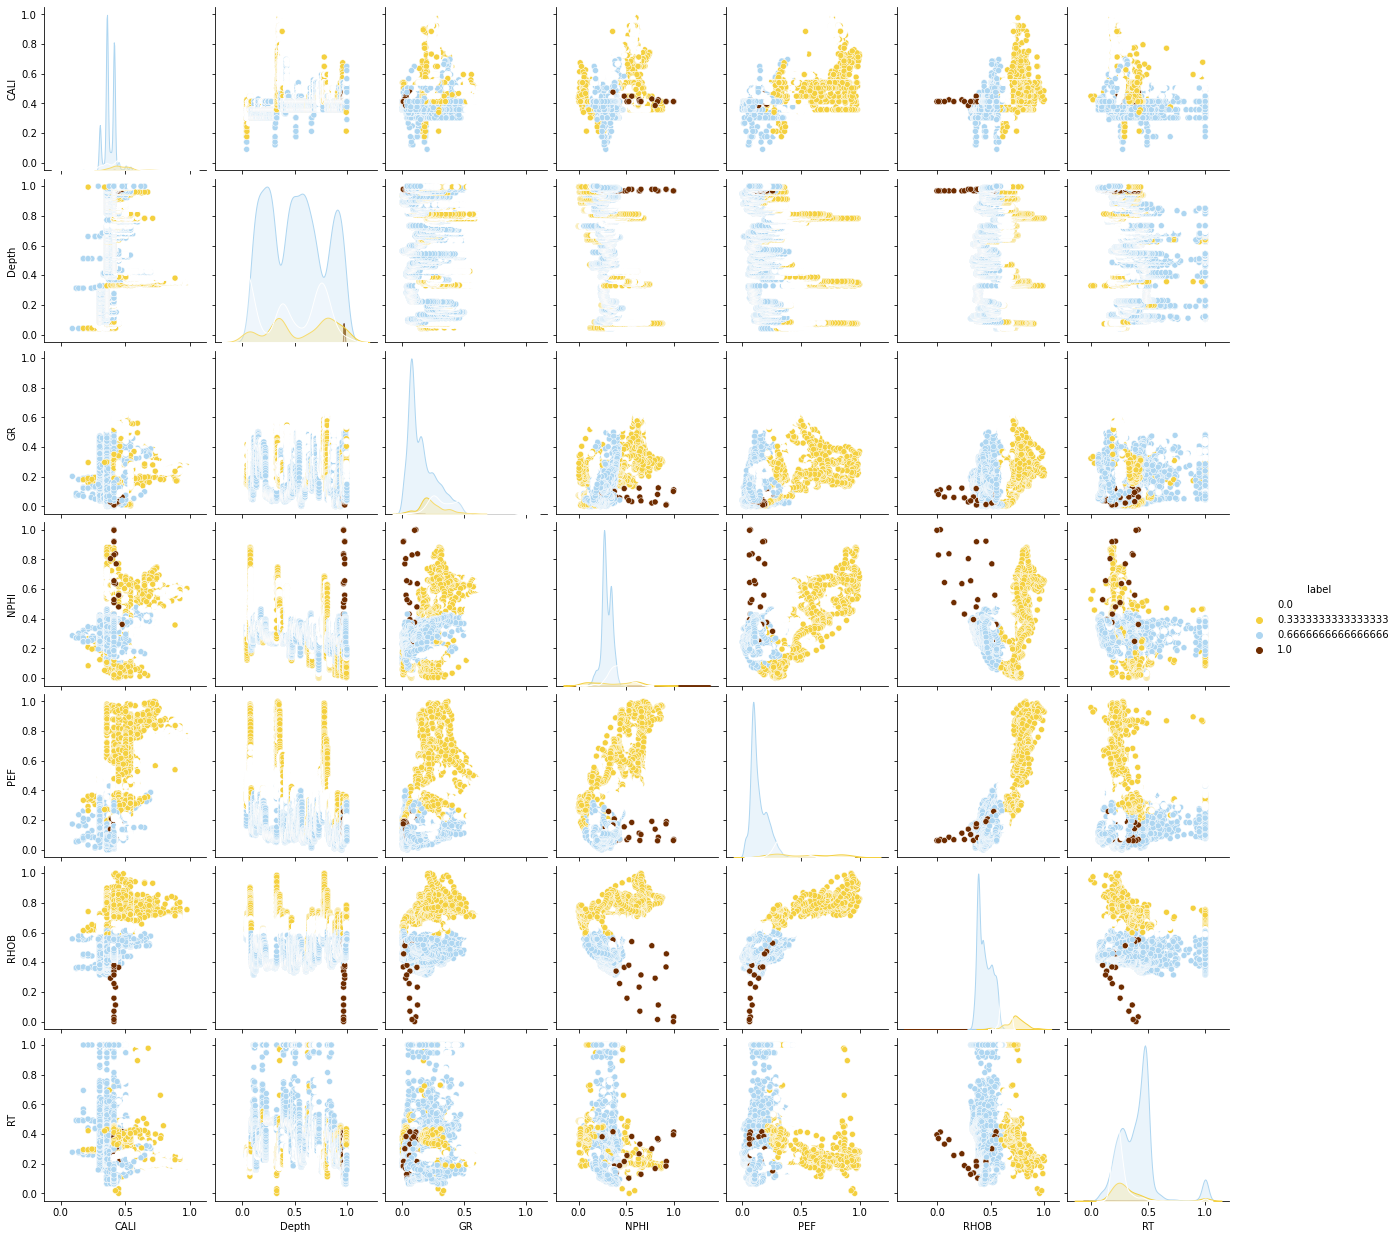

In [86]:
import seaborn as sns
sns.pairplot(df_normalized, hue ='label', palette=facies_colors)

### 3.b Test normality of features ###

A **histogram** is a representation of the distribution of data. It groups the values of all given Series in the DataFrame into bins.

               Depth                                                    \
               count      mean       std       min       25%       50%   
label NPHI                                                               
0.0   0.030948   1.0  0.730993       NaN  0.730993  0.730993  0.730993   
      0.032882   2.0  0.731244  0.000051  0.731208  0.731226  0.731244   
      0.034816   2.0  0.731101  0.000051  0.731065  0.731083  0.731101   
      0.036750   1.0  0.731352       NaN  0.731352  0.731352  0.731352   
      0.038685   1.0  0.731424       NaN  0.731424  0.731424  0.731424   
...              ...       ...       ...       ...       ...       ...   
1.0   0.837524   1.0  0.968196       NaN  0.968196  0.968196  0.968196   
      0.918762   1.0  0.979037       NaN  0.979037  0.979037  0.979037   
      0.922631   1.0  0.978965       NaN  0.978965  0.978965  0.978965   
      0.996132   1.0  0.968339       NaN  0.968339  0.968339  0.968339   
      1.000000   1.0  0.968268       N

C:\Users\ndang\anaconda3\envs\data_science_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


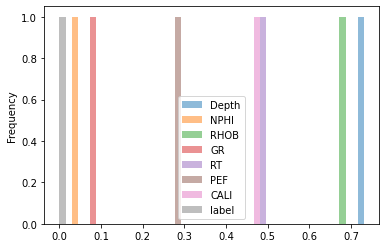

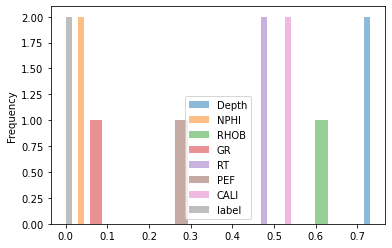

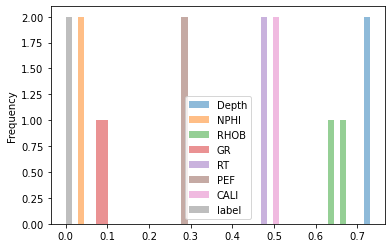

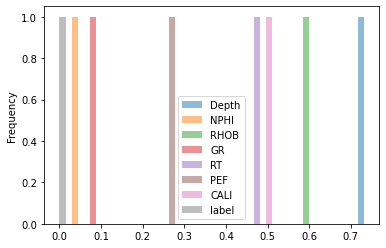

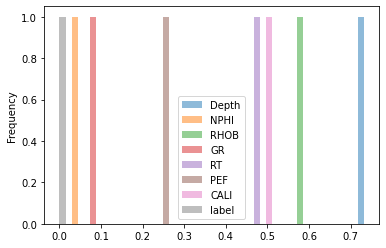

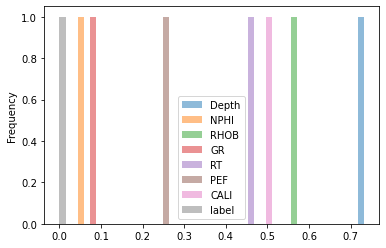

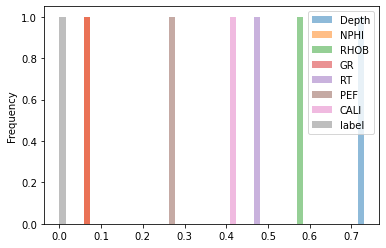

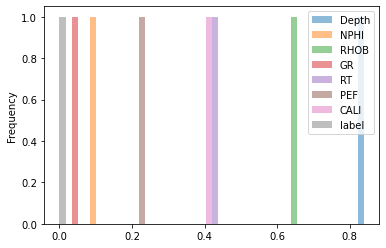

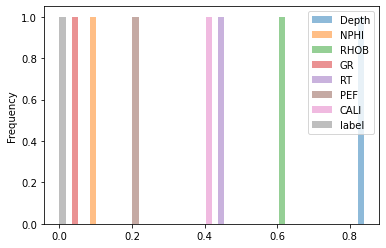

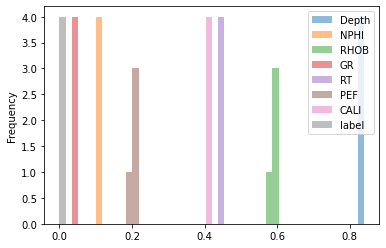

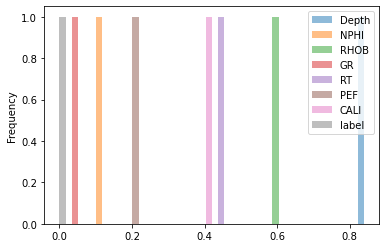

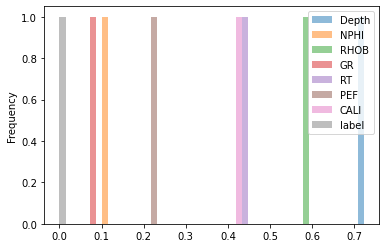

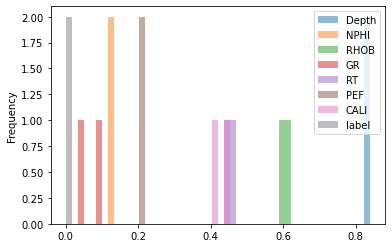

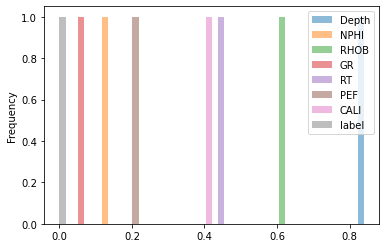

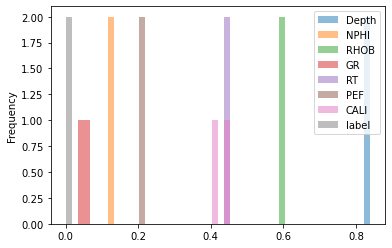

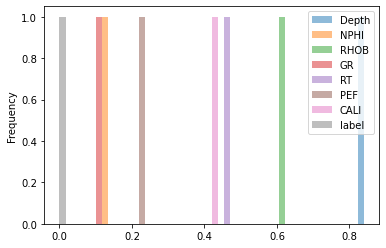

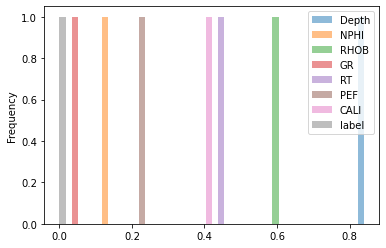

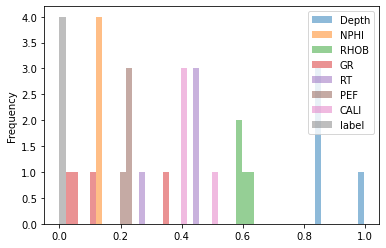

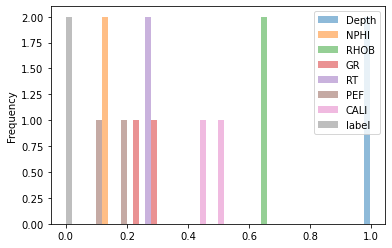

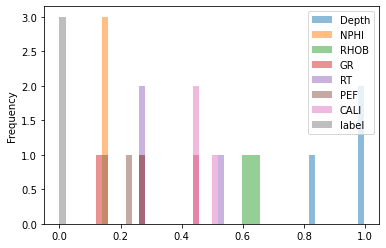

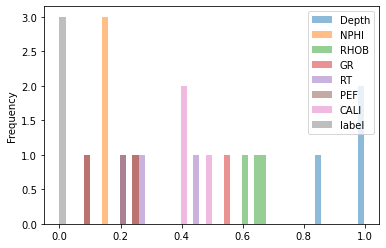

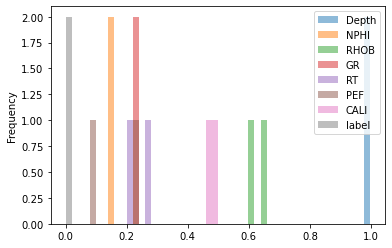

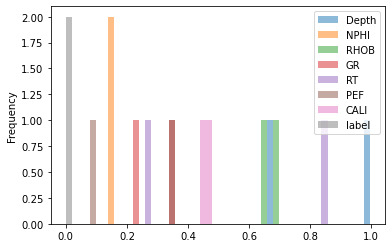

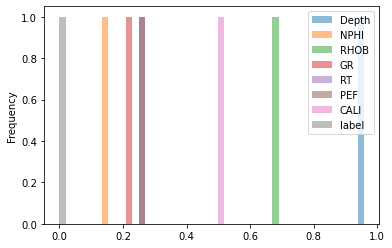

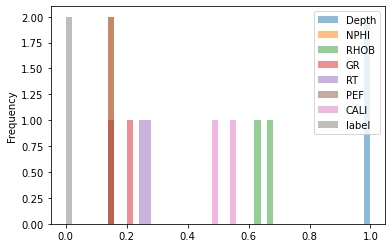

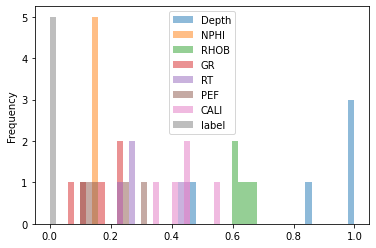

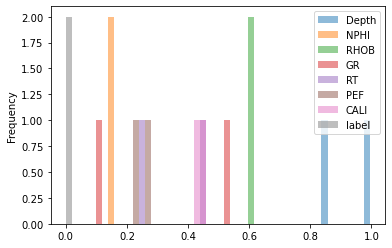

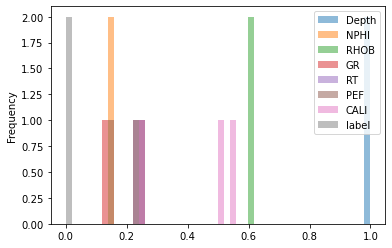

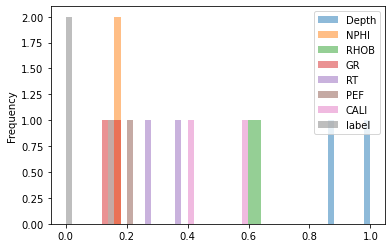

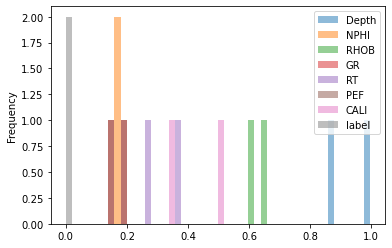

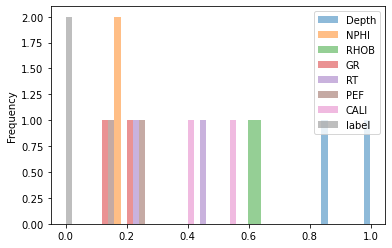

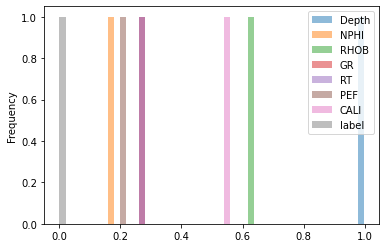

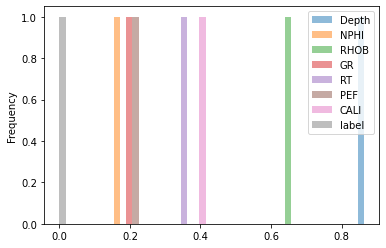

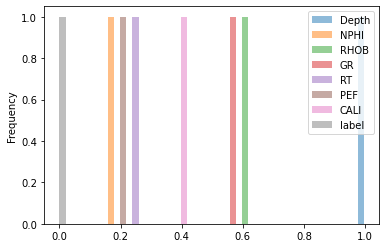

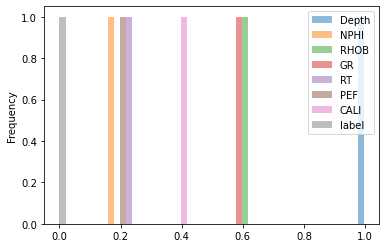

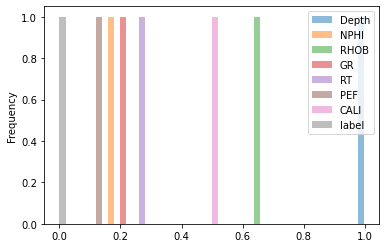

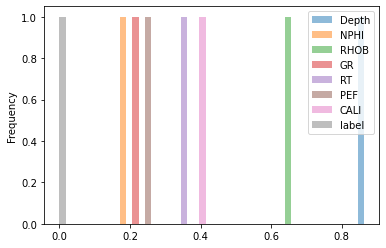

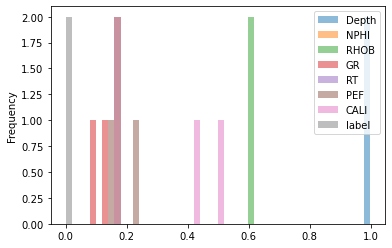

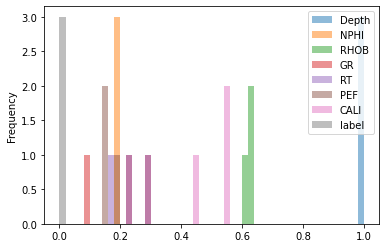

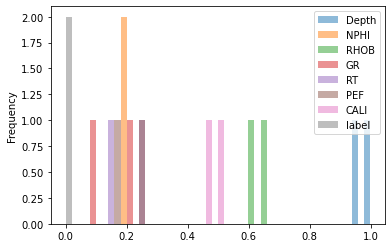

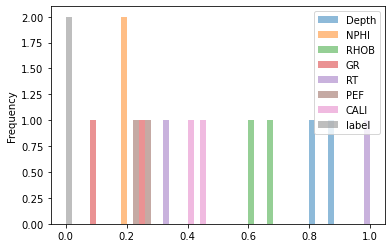

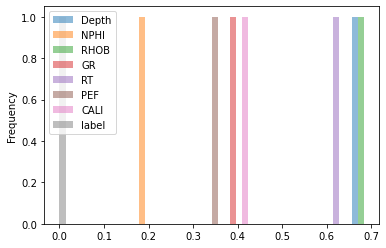

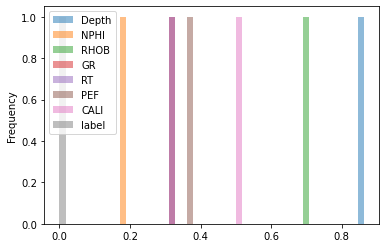

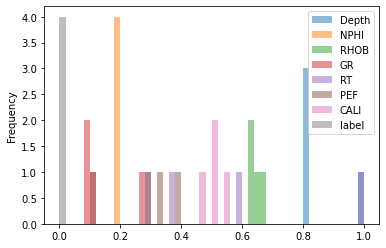

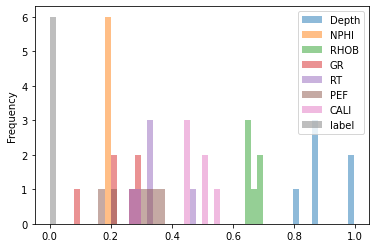

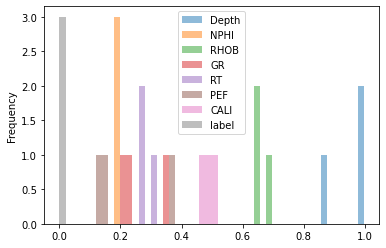

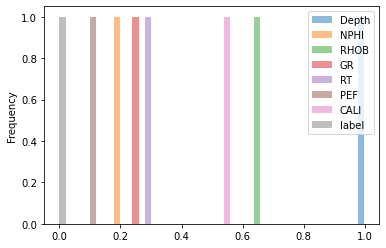

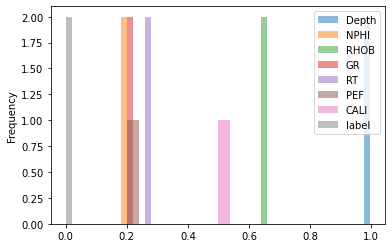

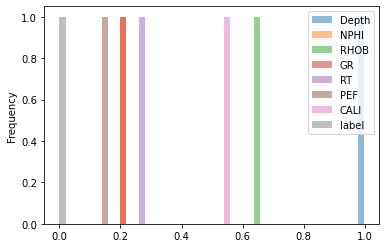

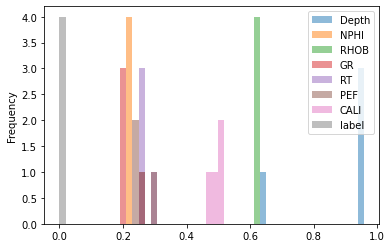

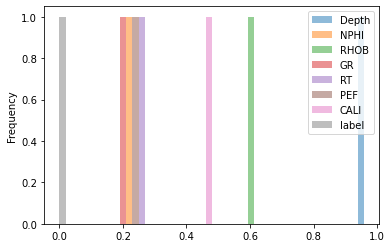

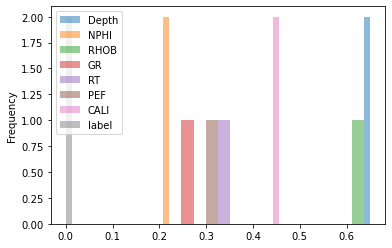

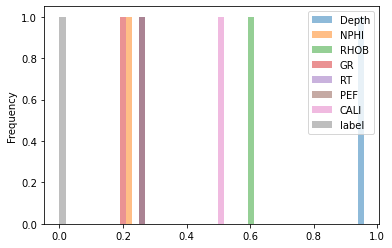

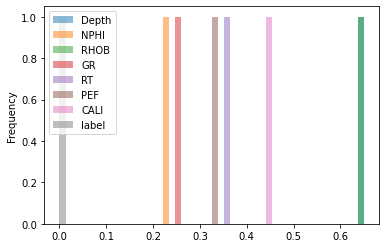

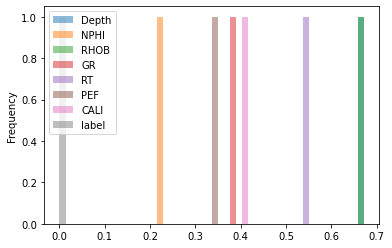

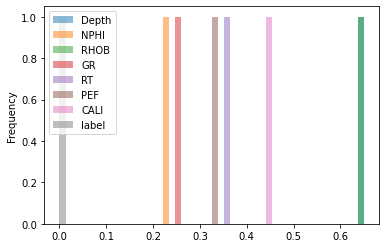

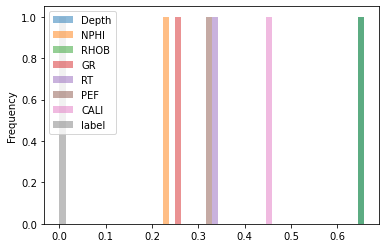

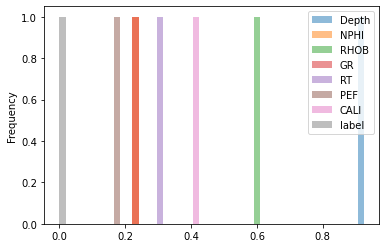

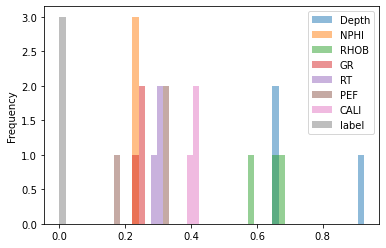

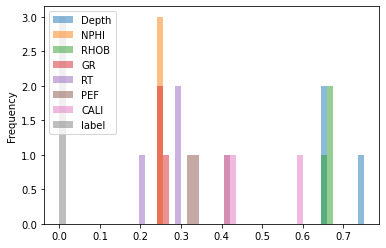

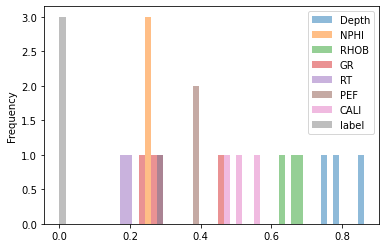

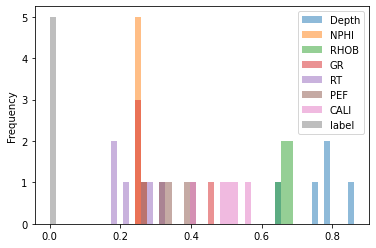

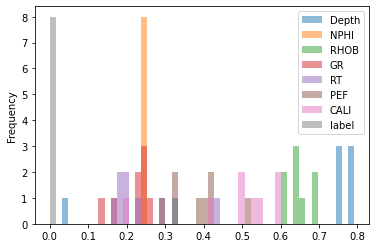

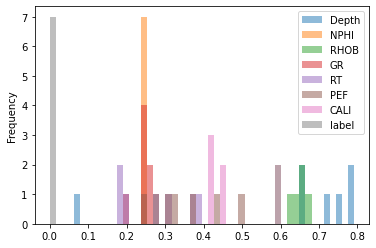

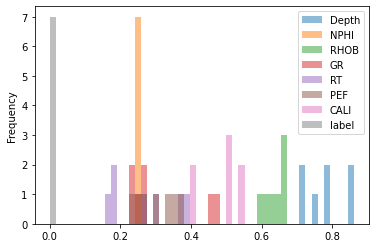

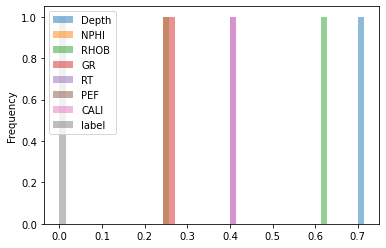

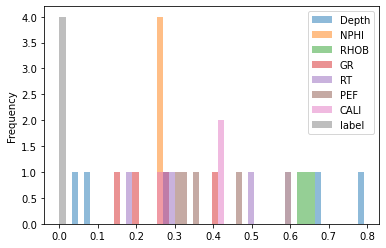

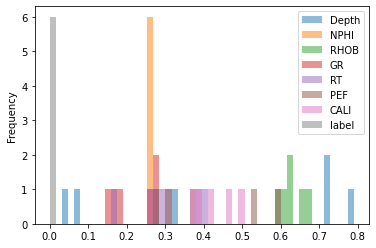

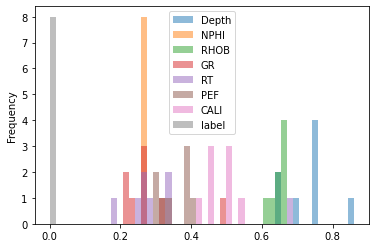

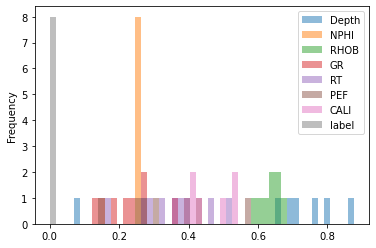

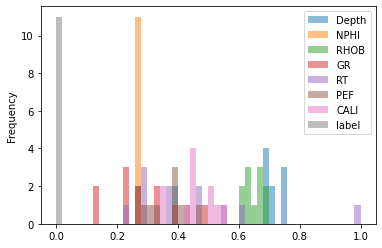

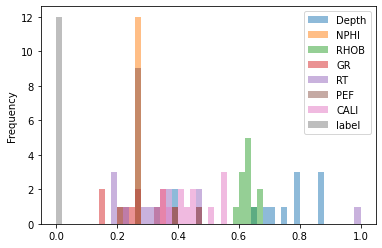

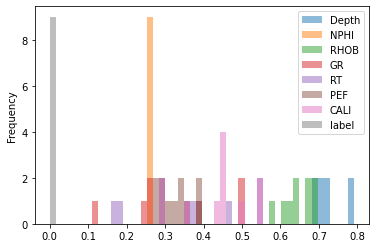

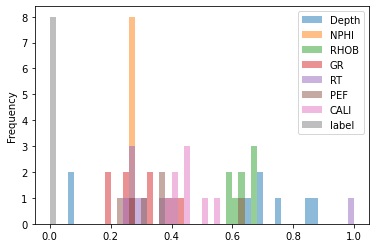

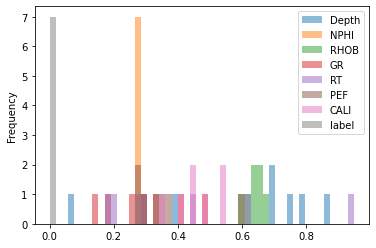

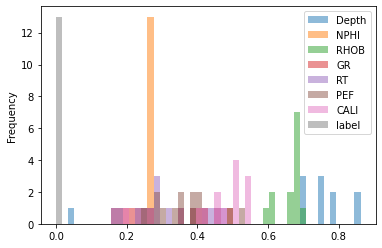

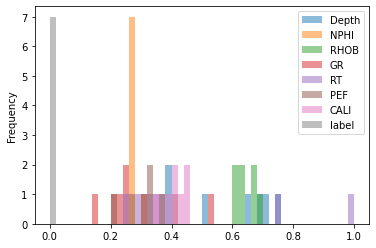

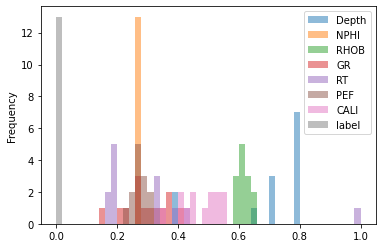

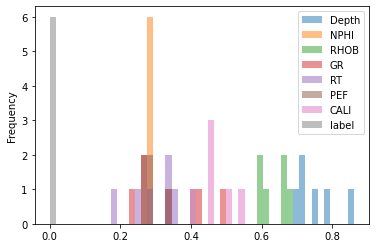

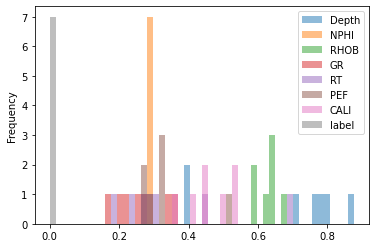

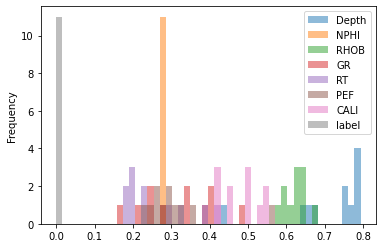

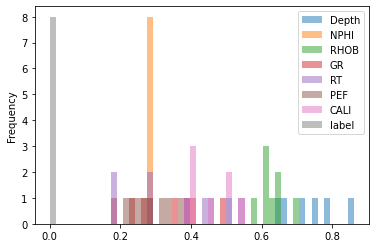

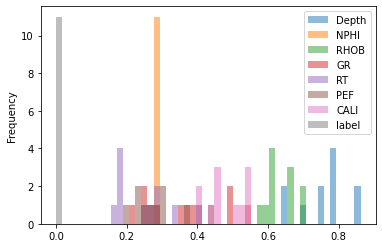

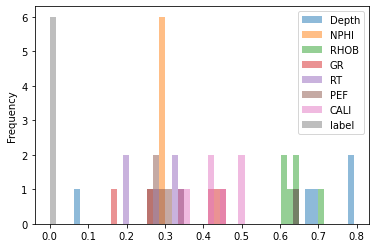

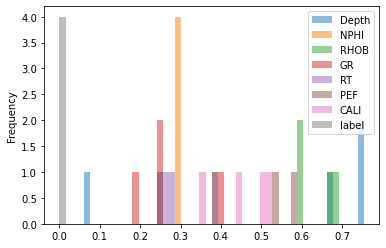

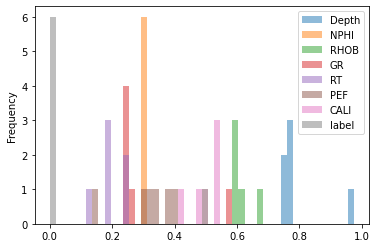

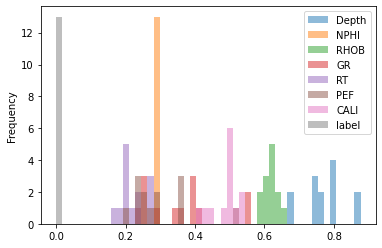

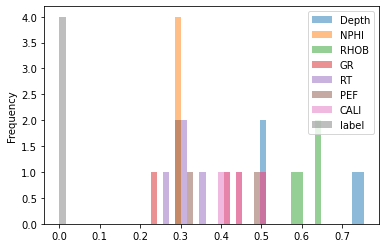

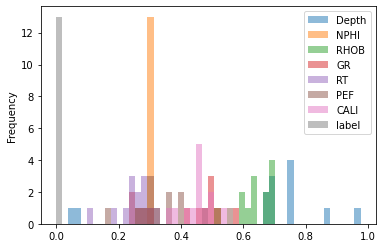

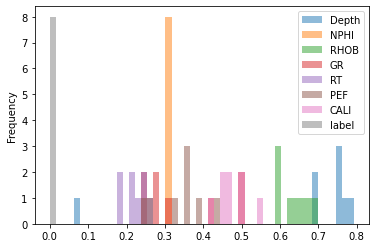

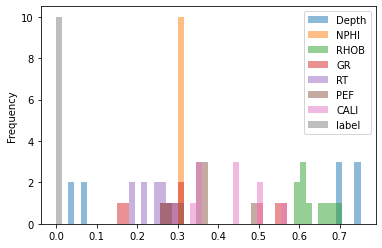

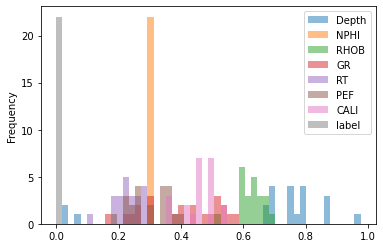

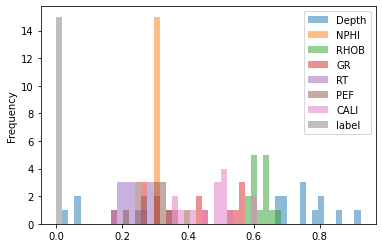

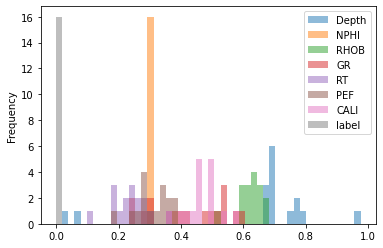

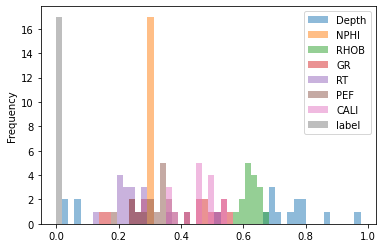

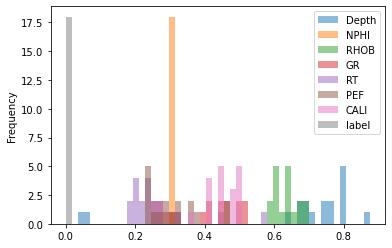

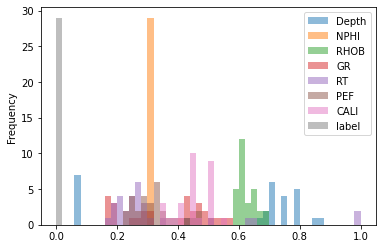

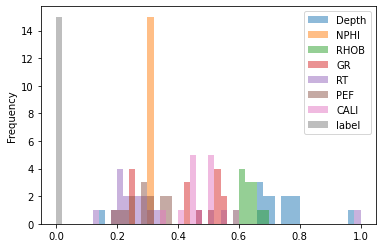

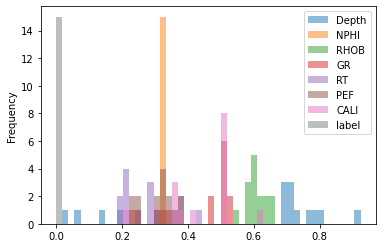

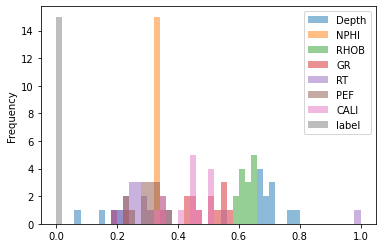

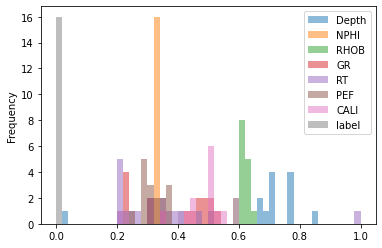

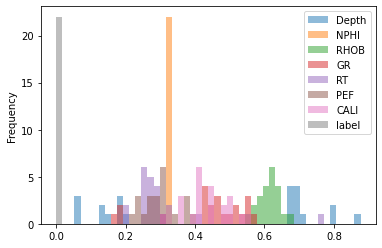

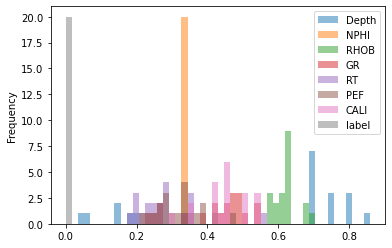

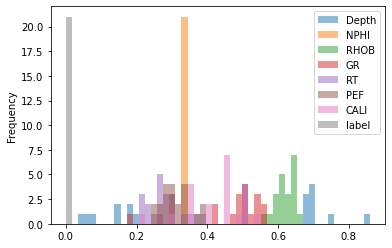

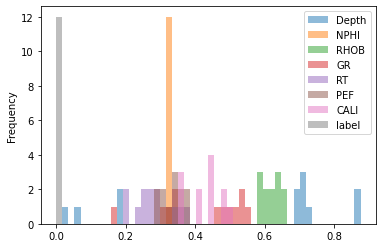

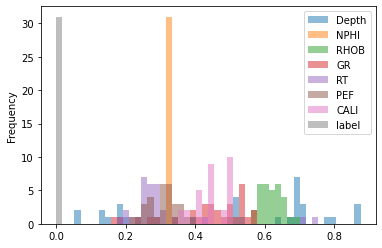

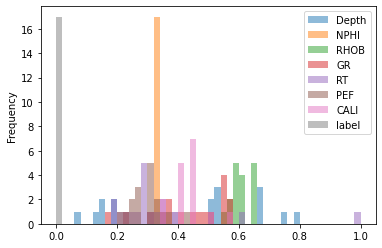

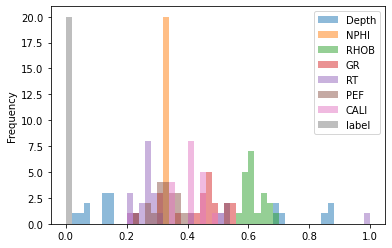

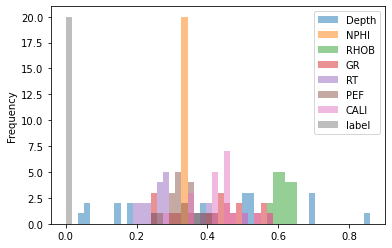

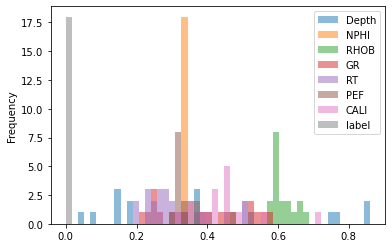

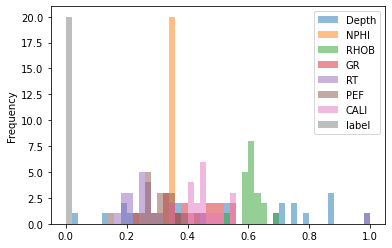

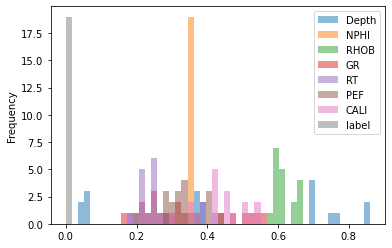

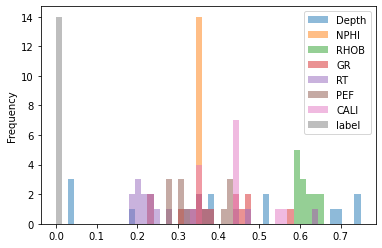

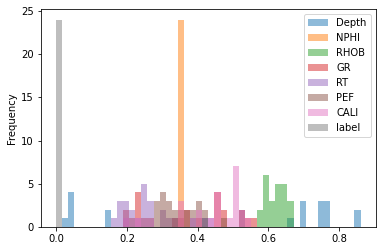

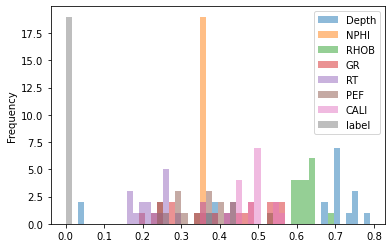

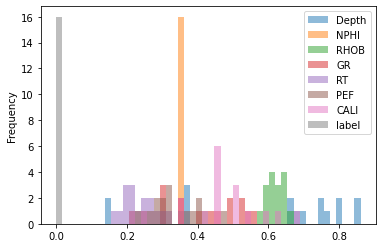

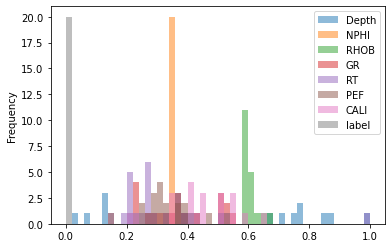

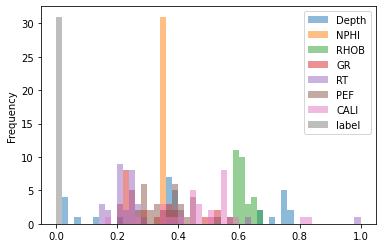

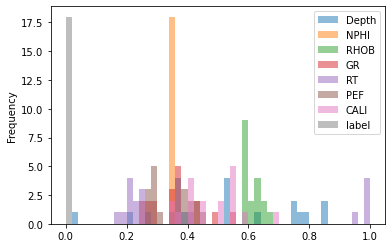

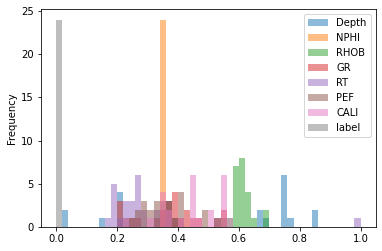

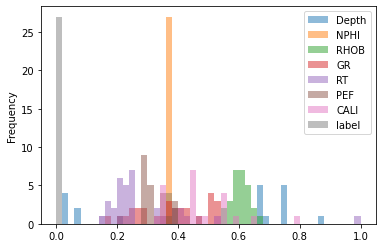

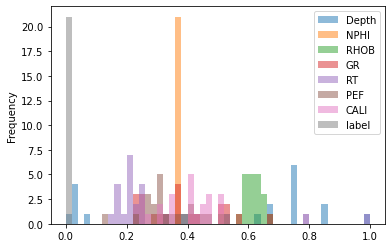

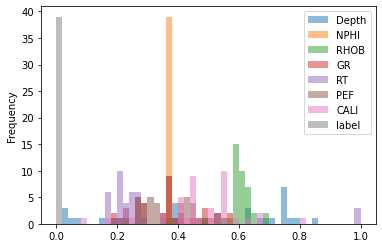

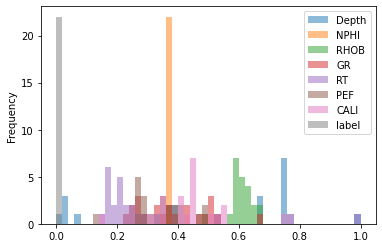

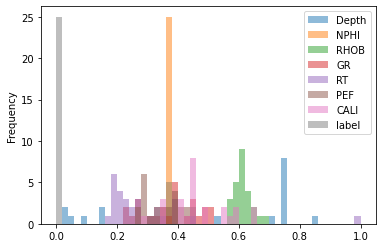

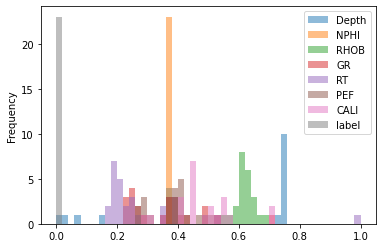

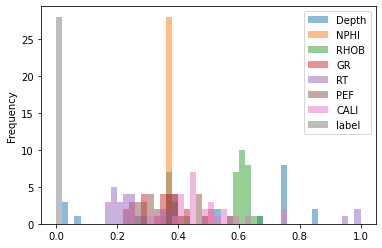

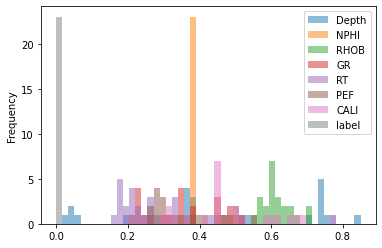

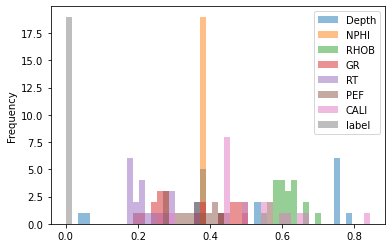

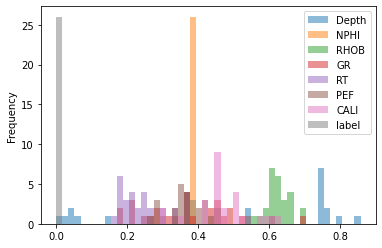

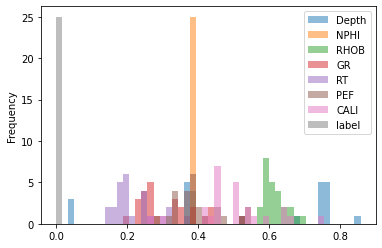

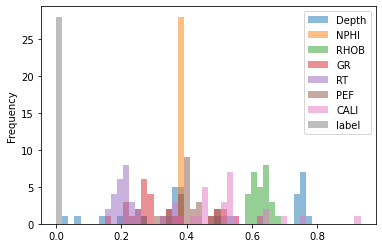

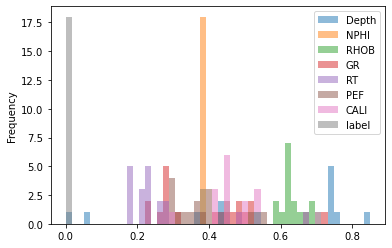

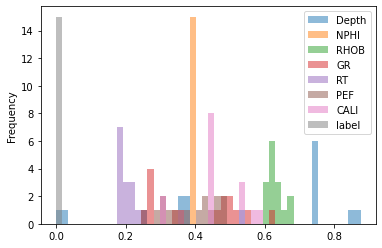

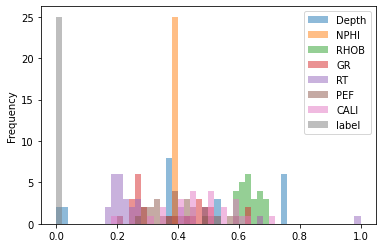

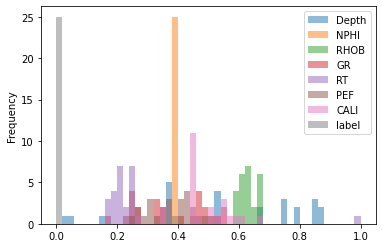

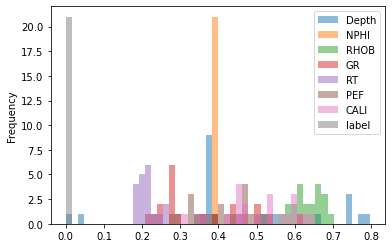

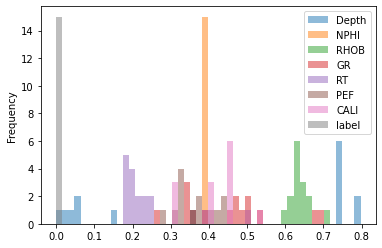

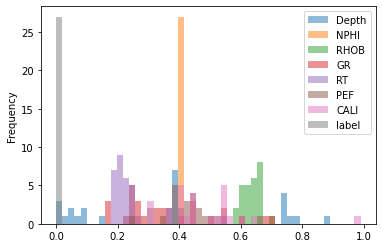

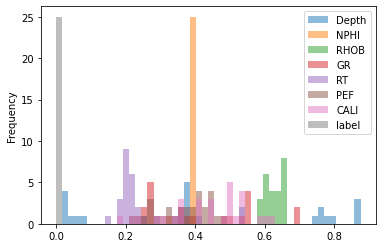

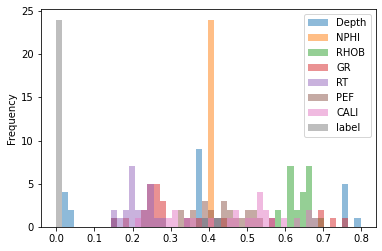

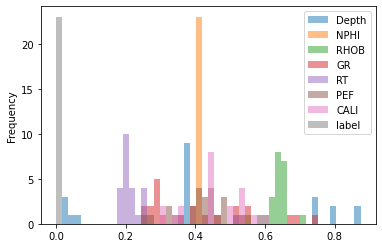

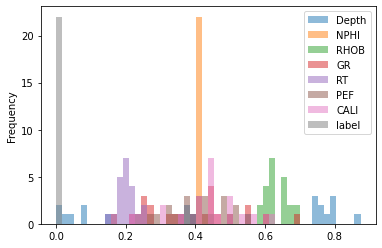

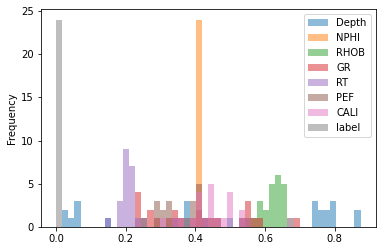

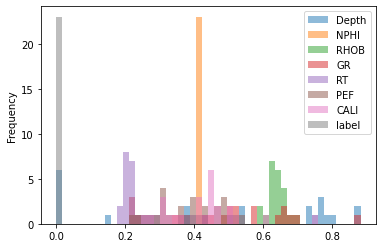

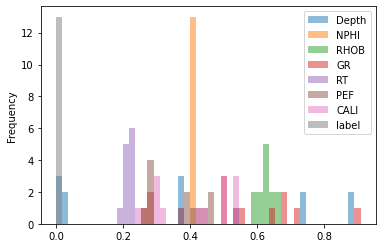

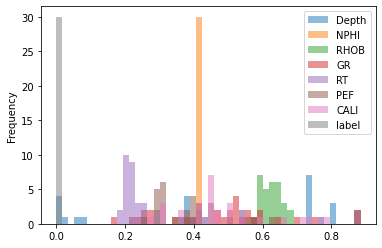

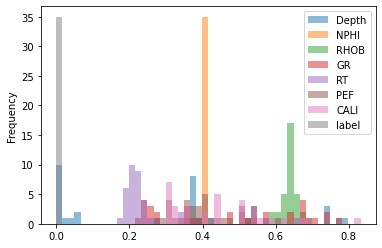

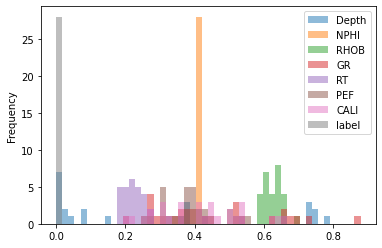

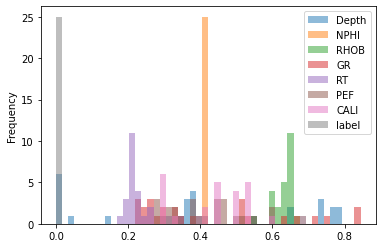

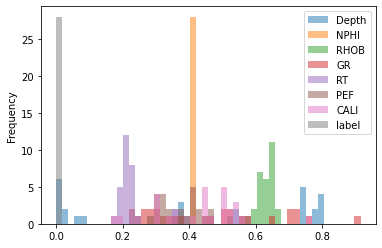

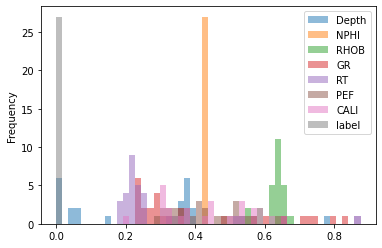

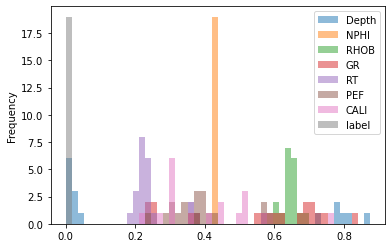

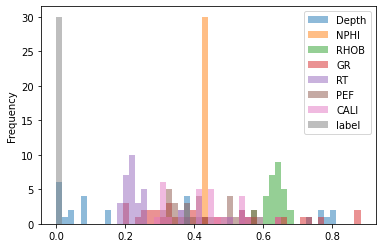

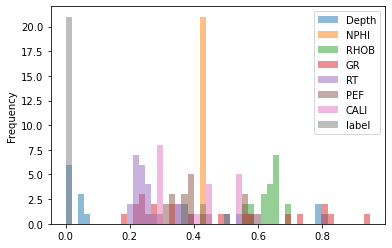

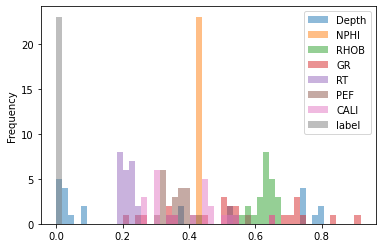

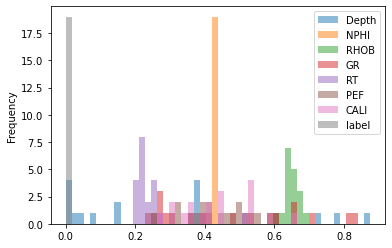

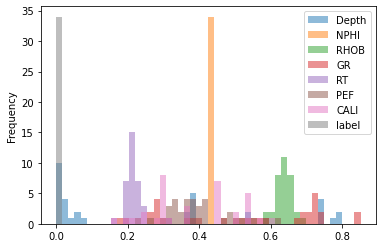

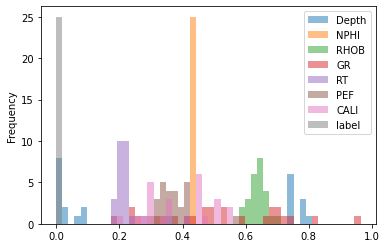

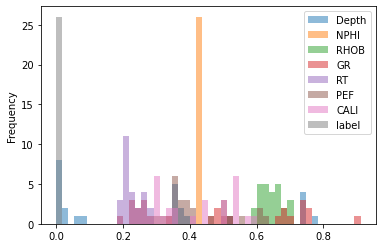

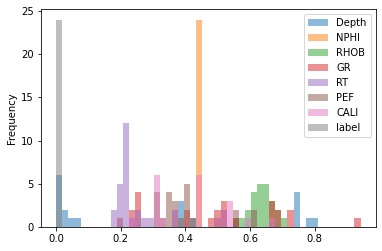

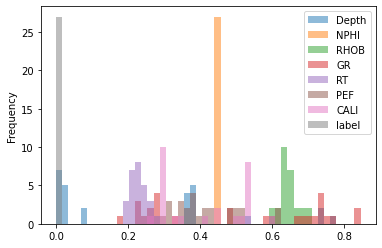

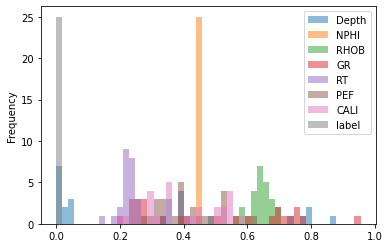

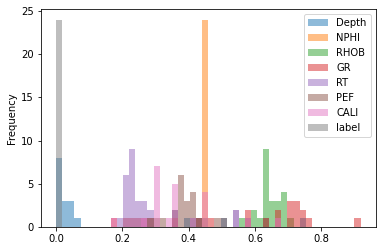

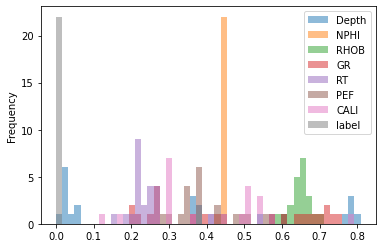

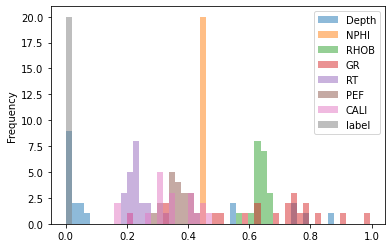

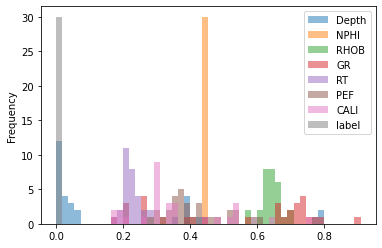

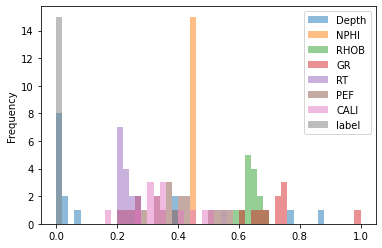

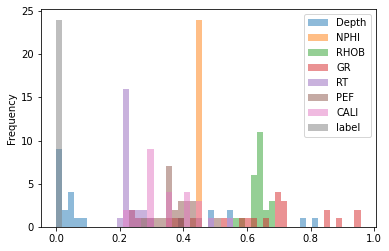

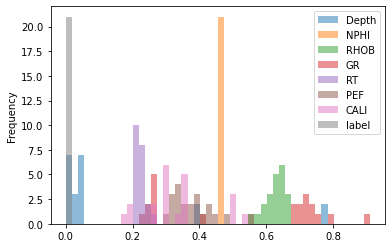

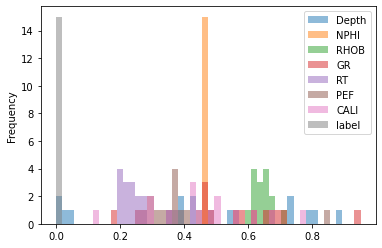

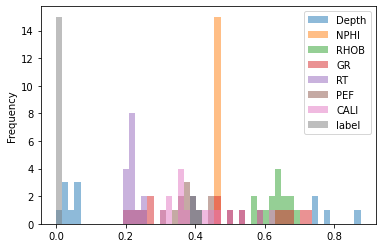

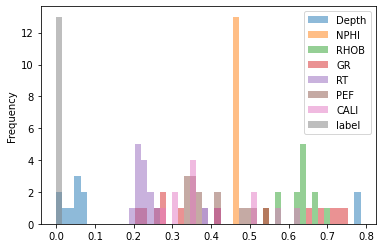

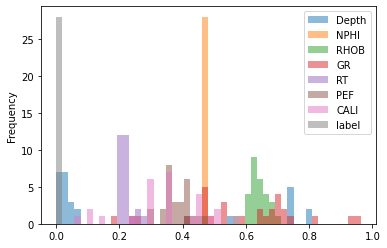

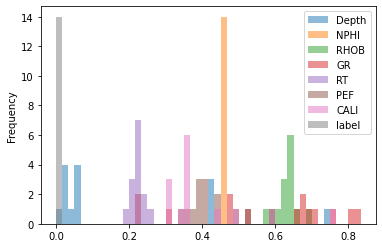

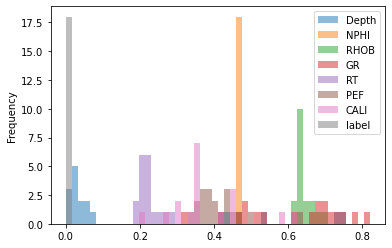

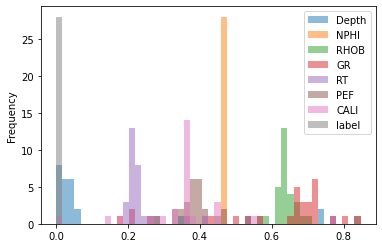

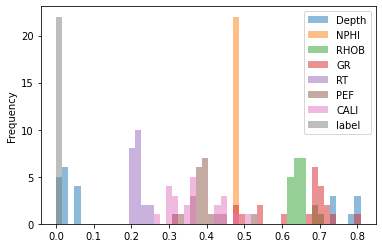

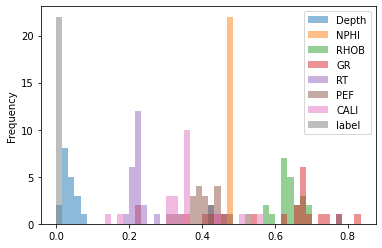

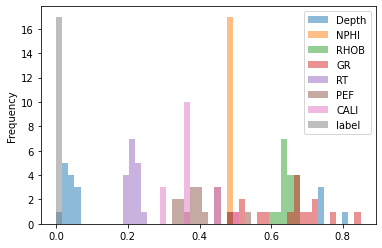

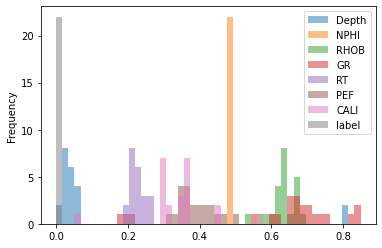

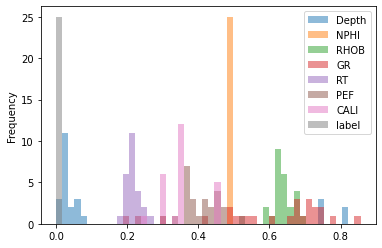

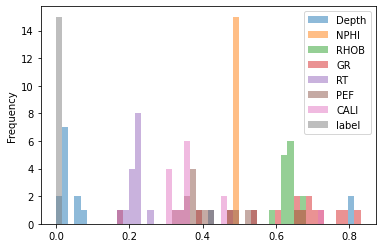

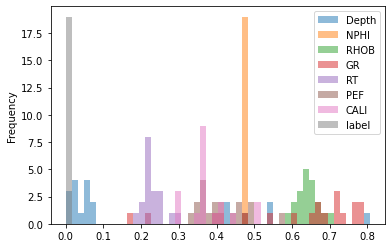

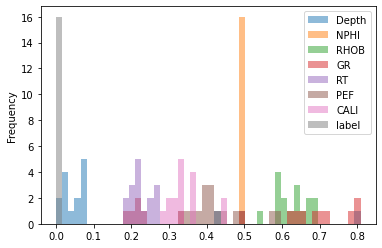

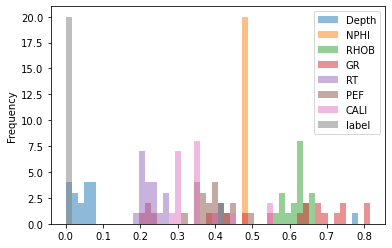

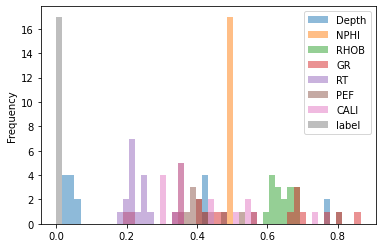

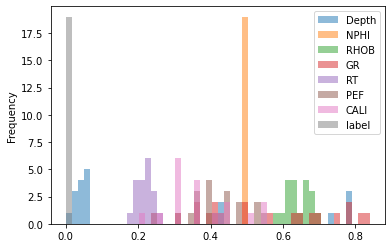

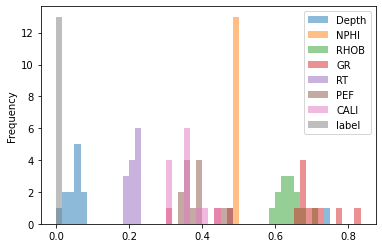

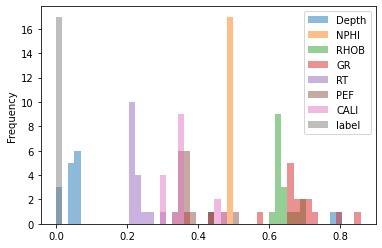

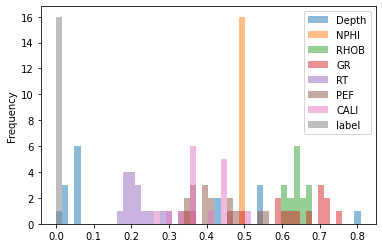

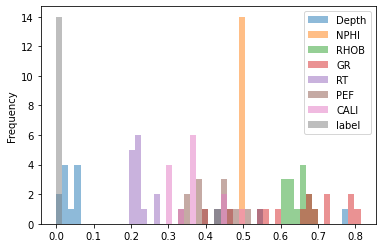

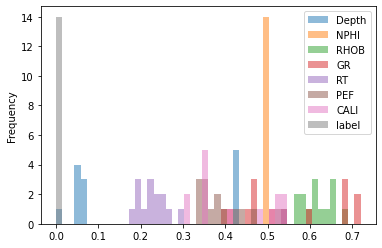

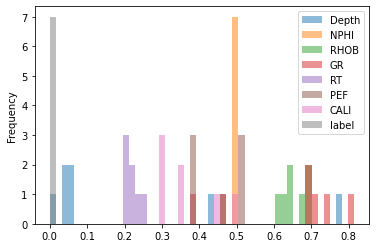

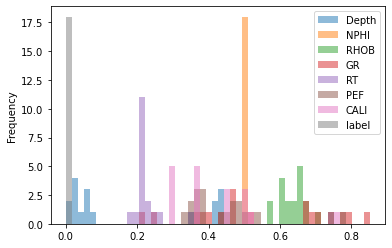

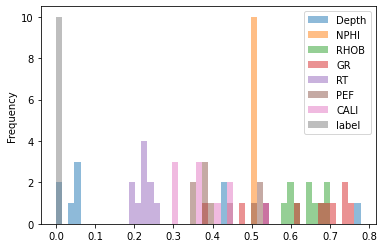

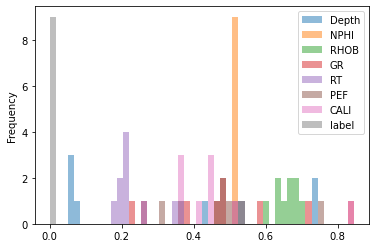

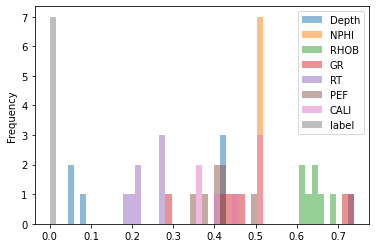

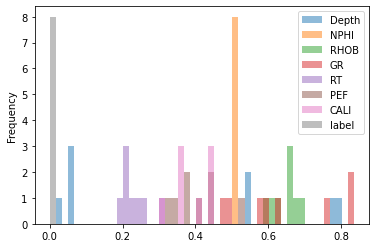

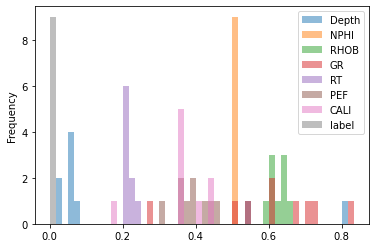

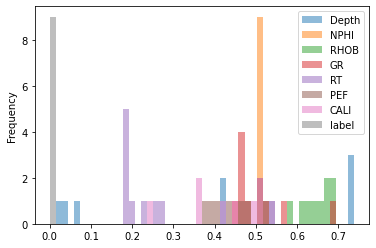

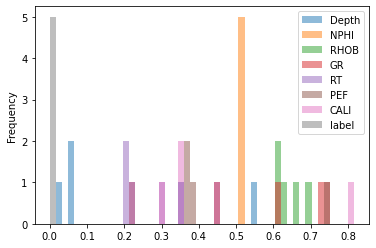

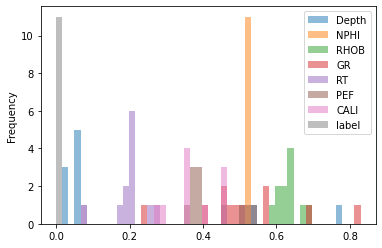

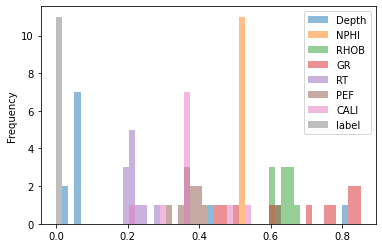

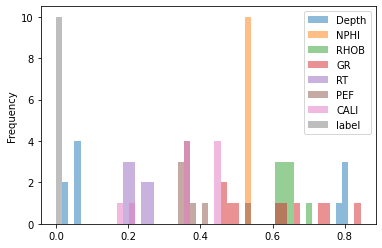

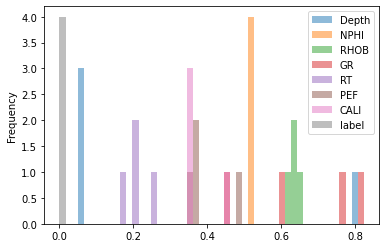

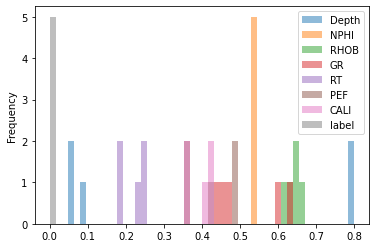

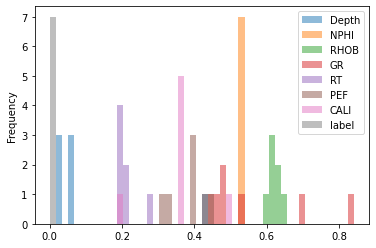

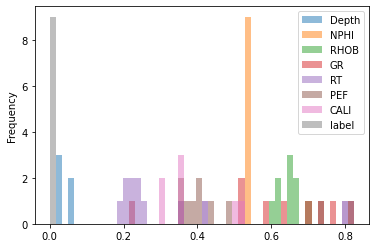

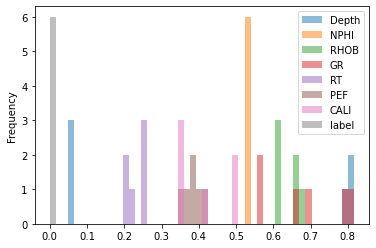

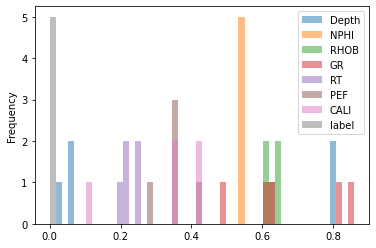

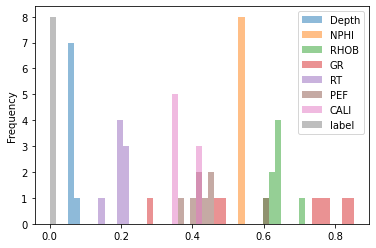

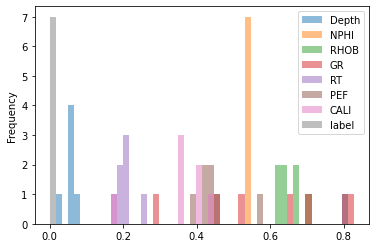

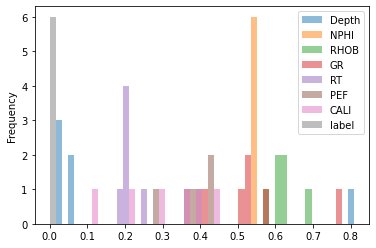

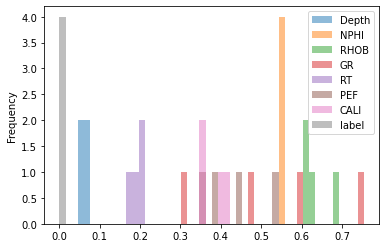

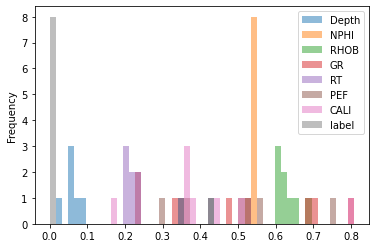

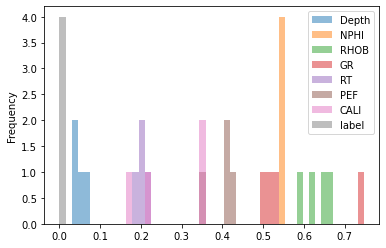

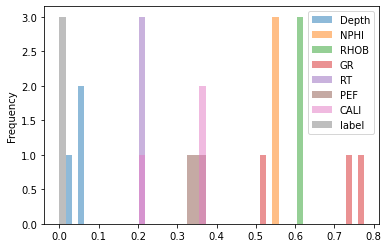

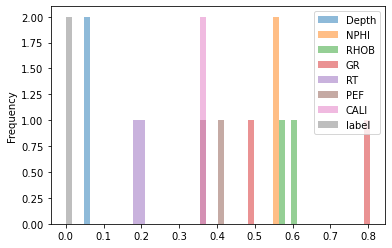

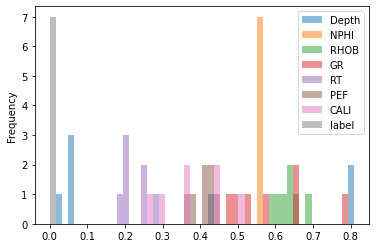

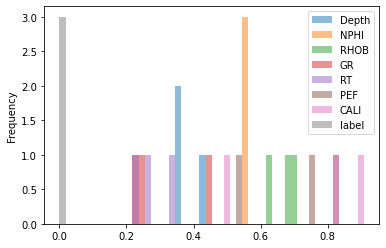

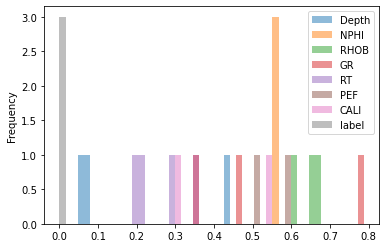

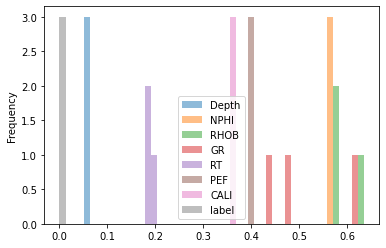

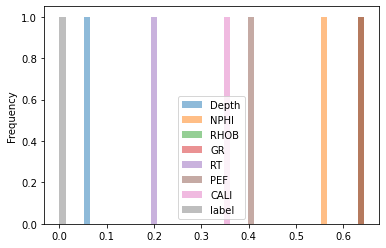

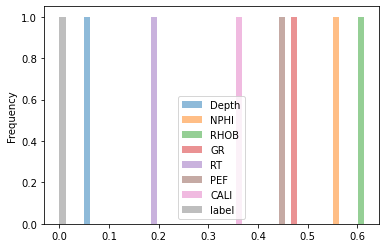

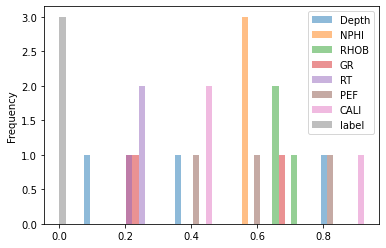

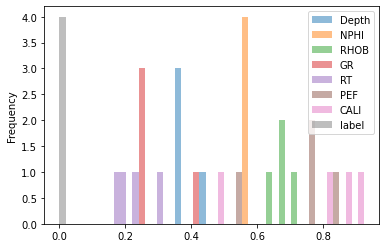

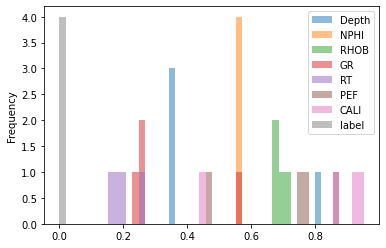

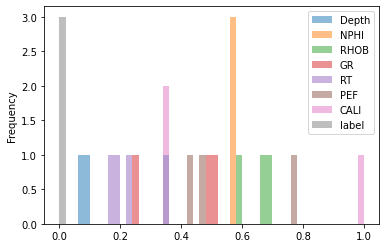

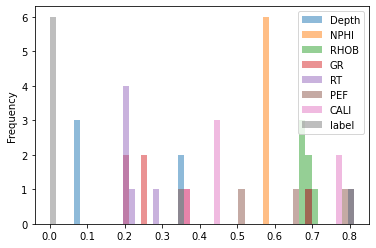

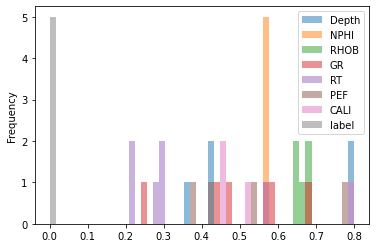

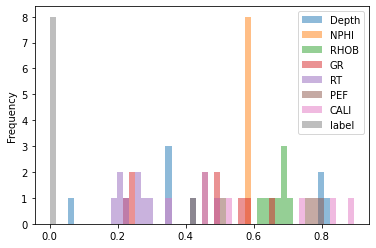

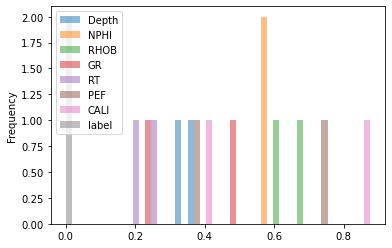

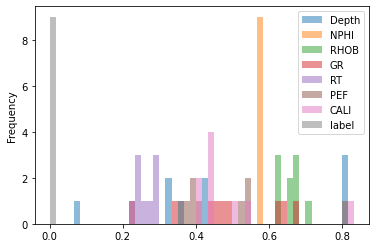

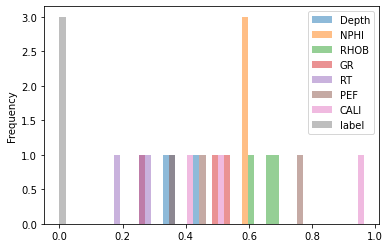

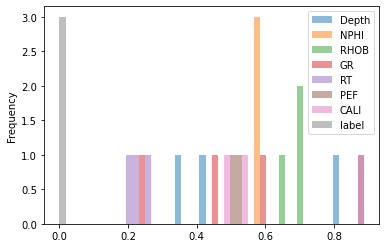

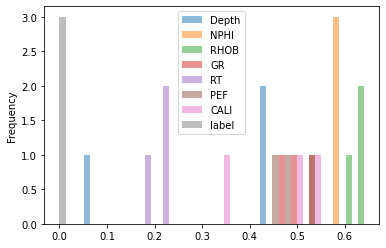

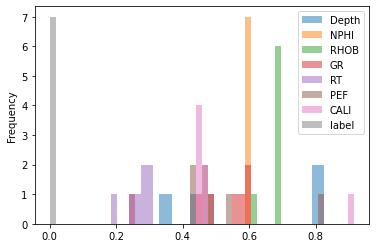

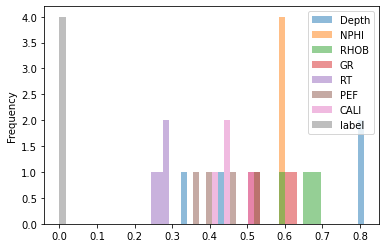

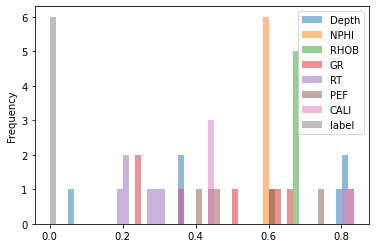

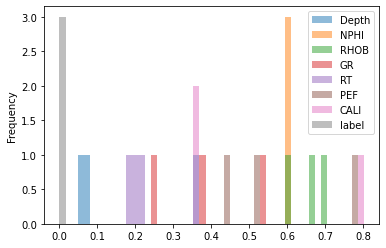

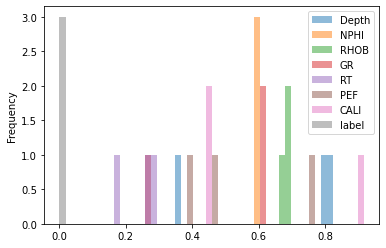

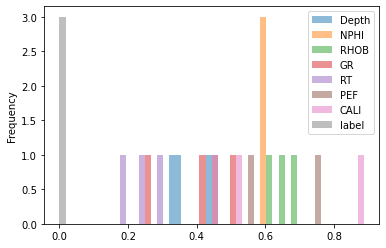

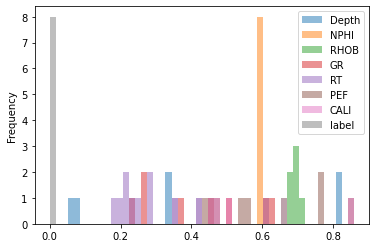

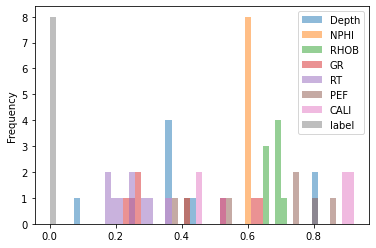

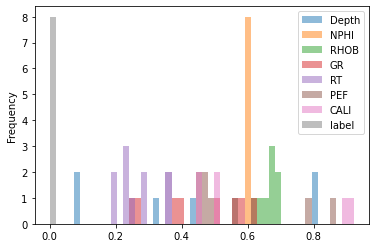

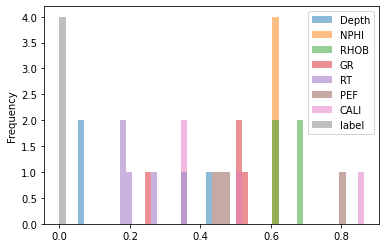

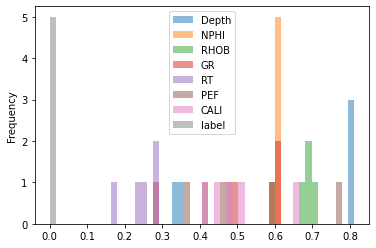

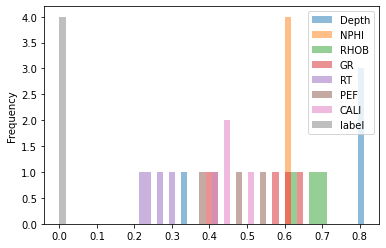

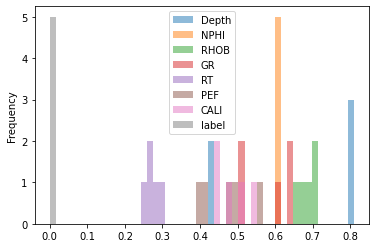

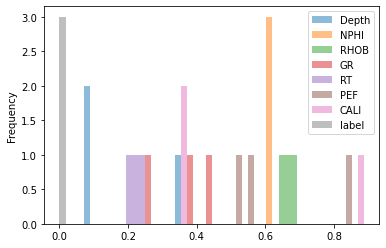

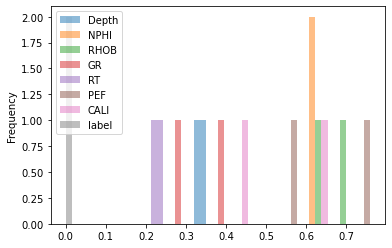

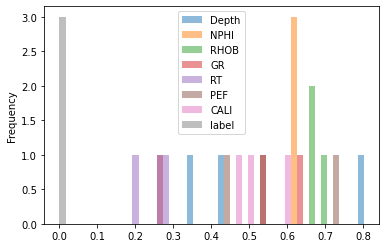

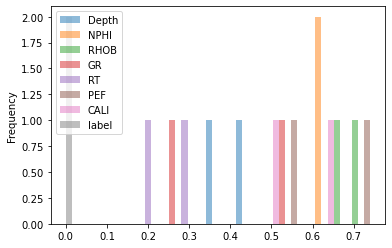

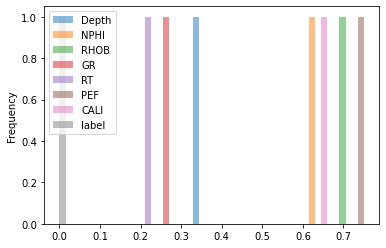

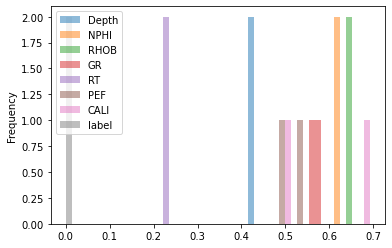

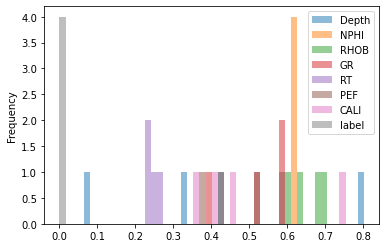

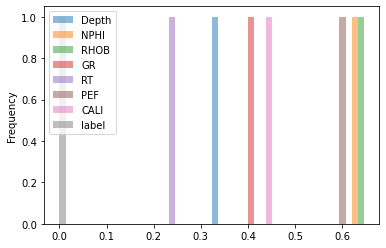

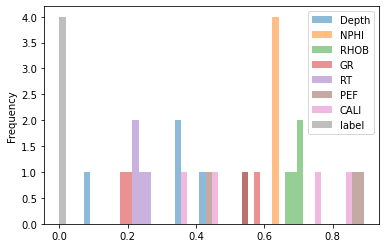

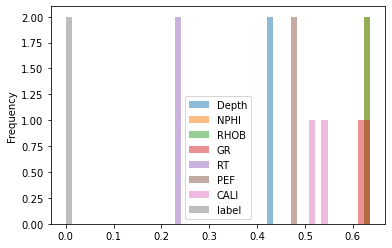

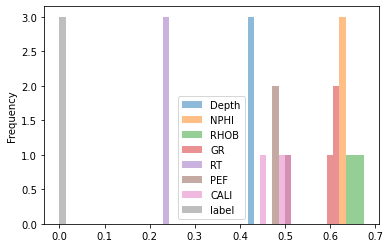

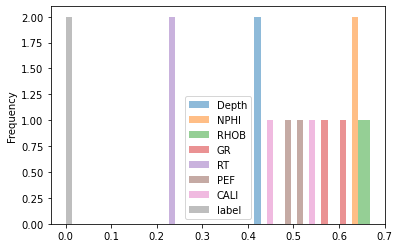

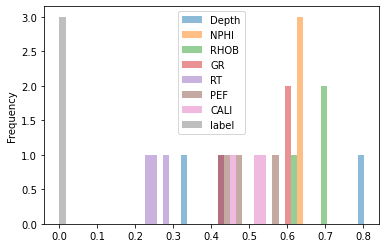

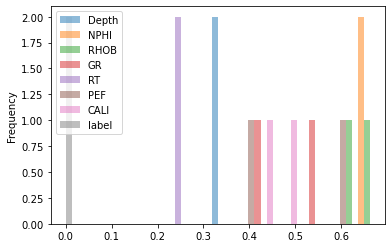

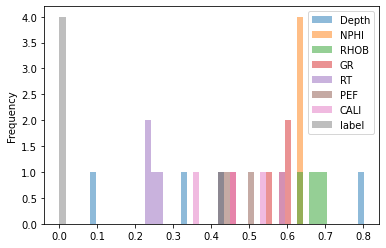

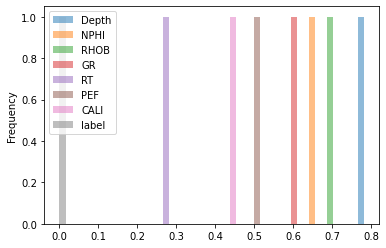

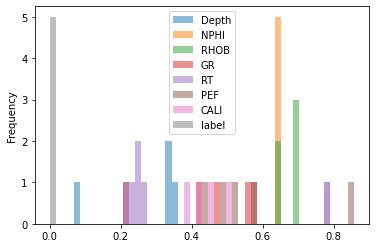

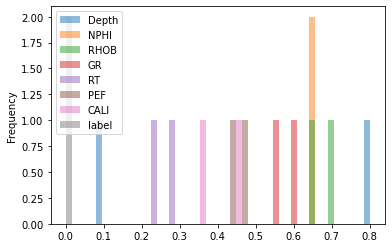

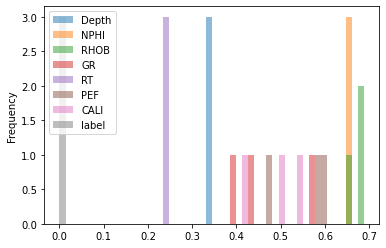

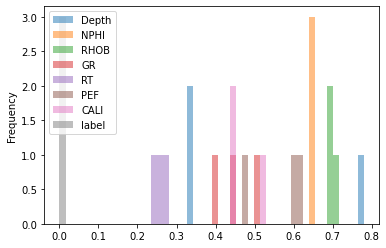

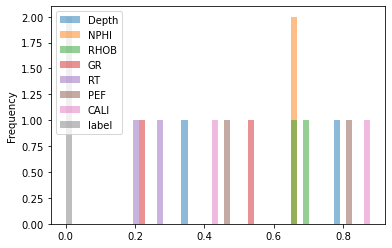

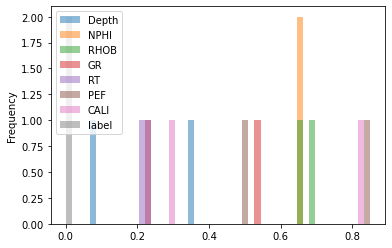

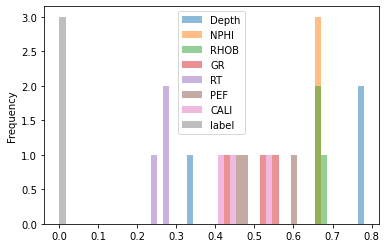

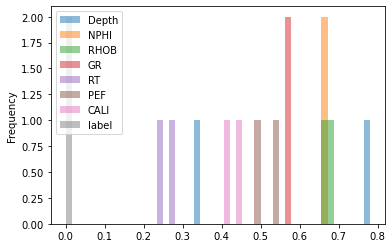

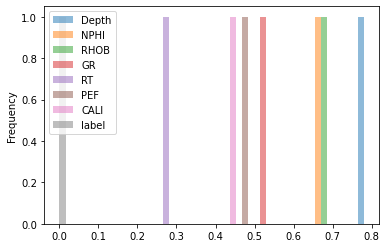

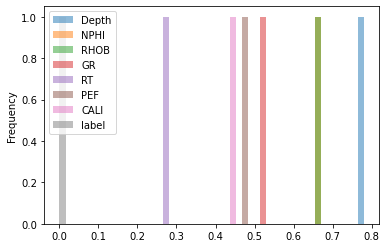

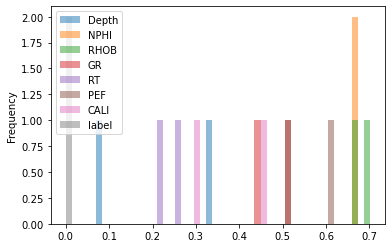

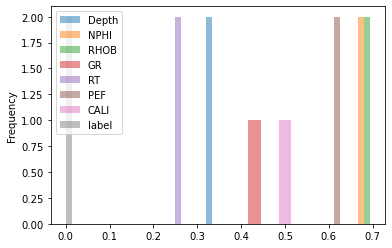

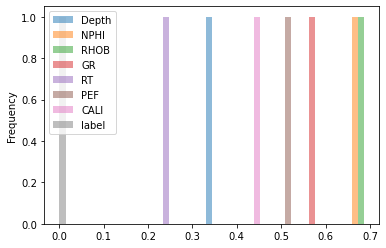

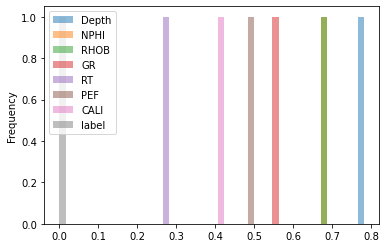

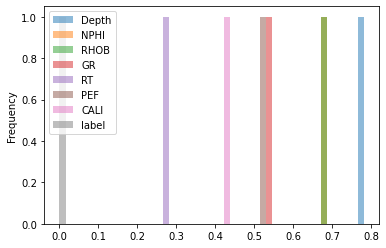

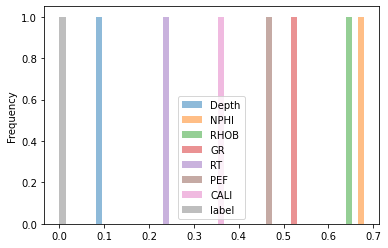

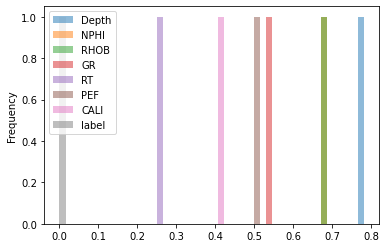

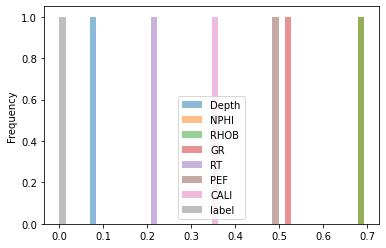

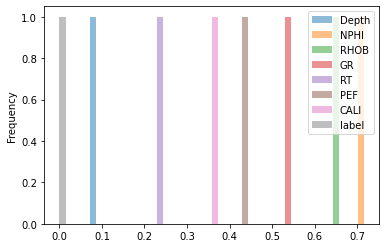

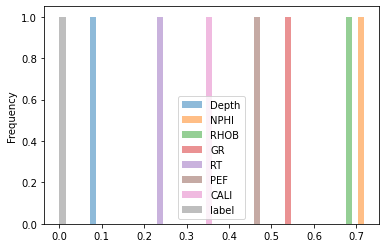

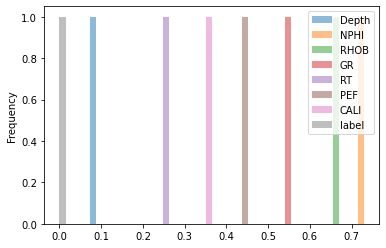

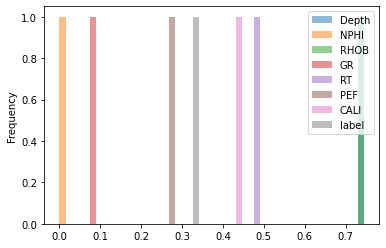

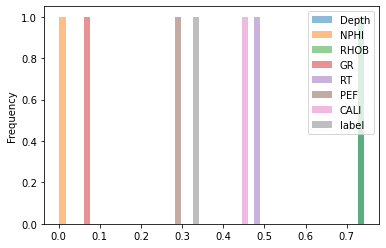

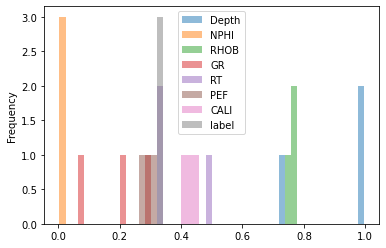

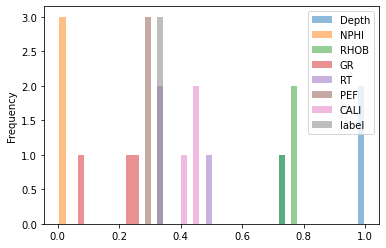

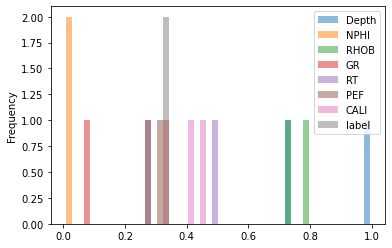

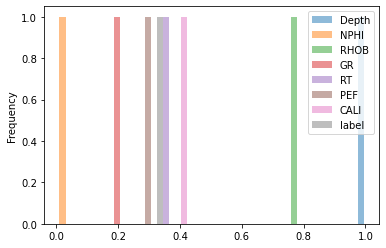

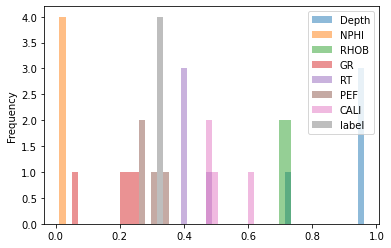

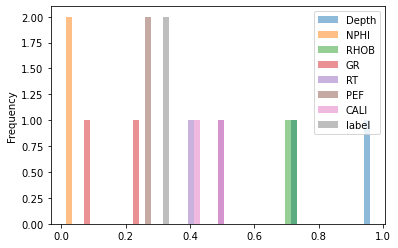

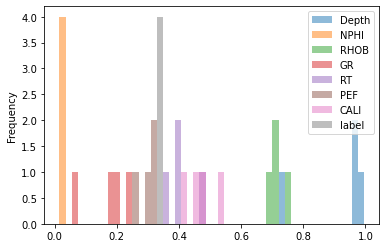

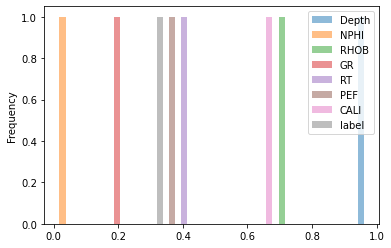

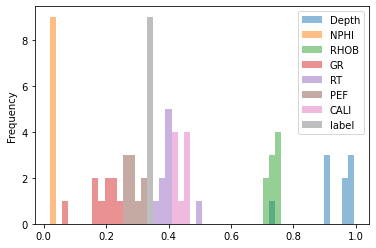

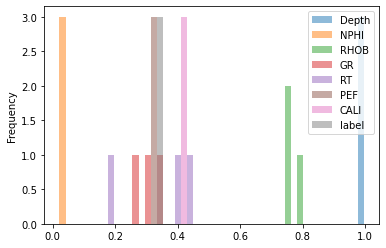

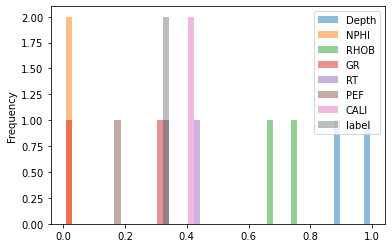

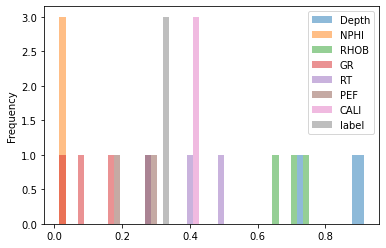

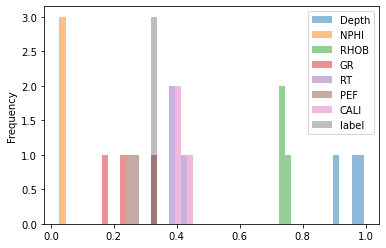

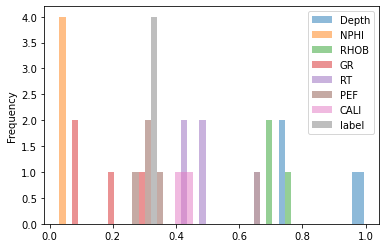

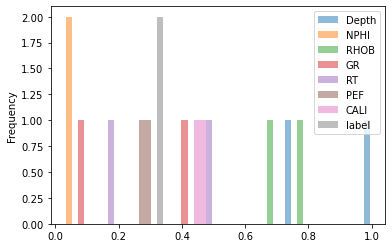

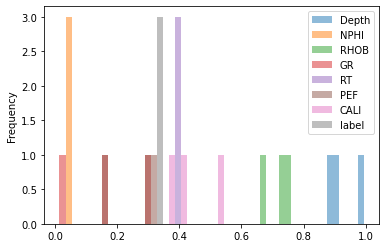

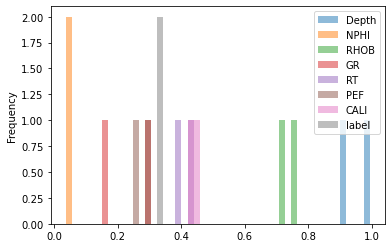

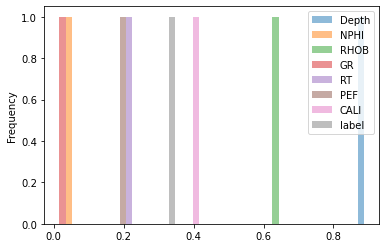

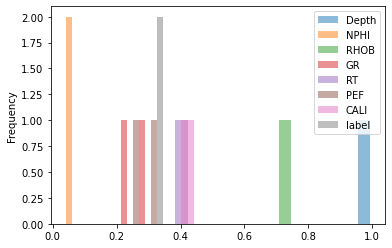

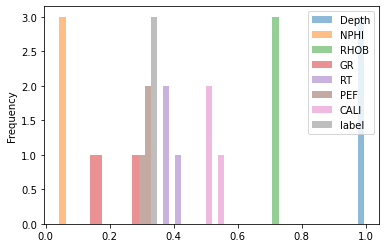

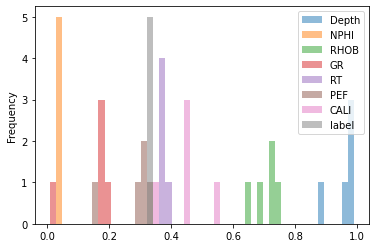

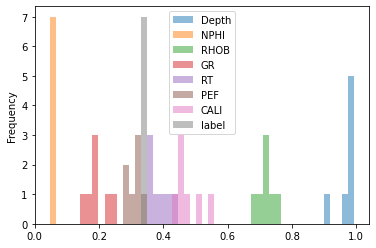

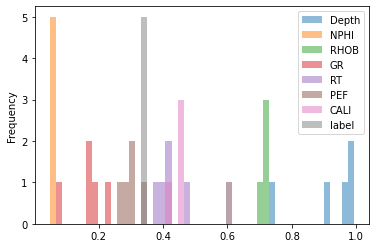

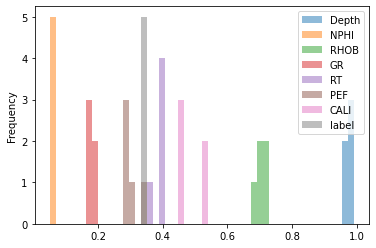

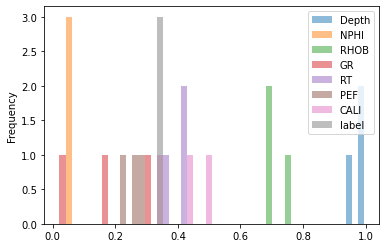

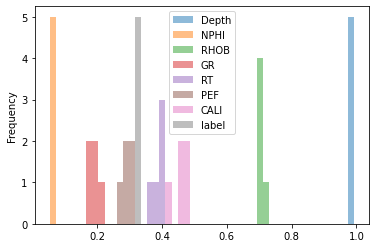

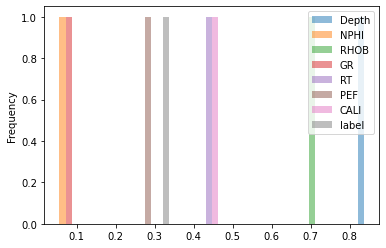

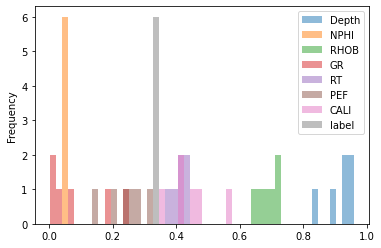

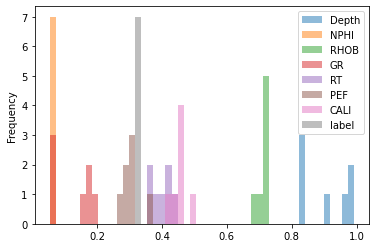

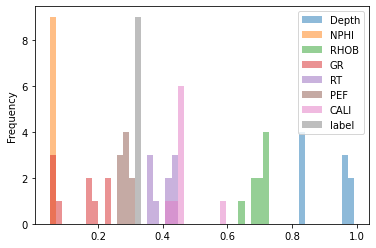

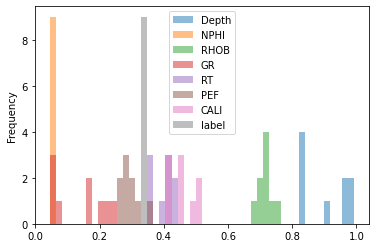

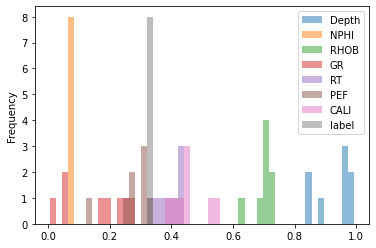

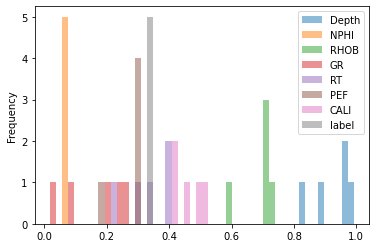

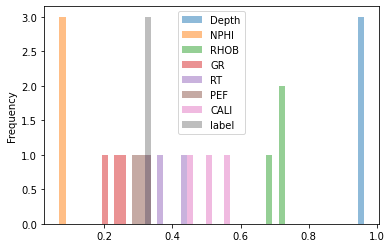

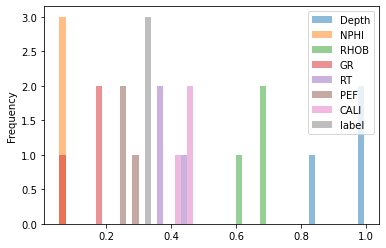

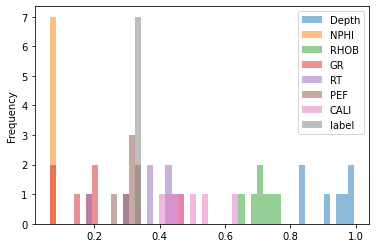

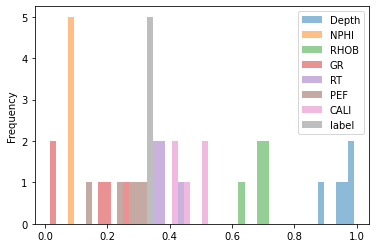

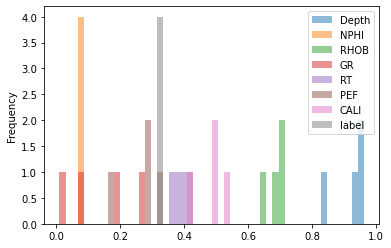

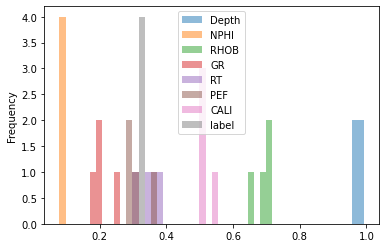

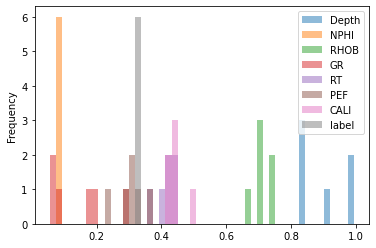

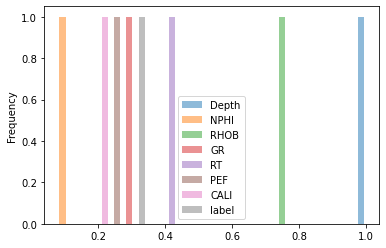

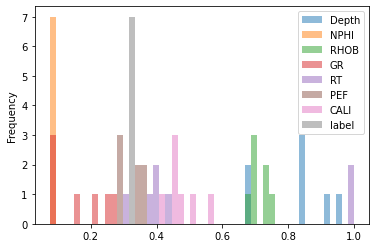

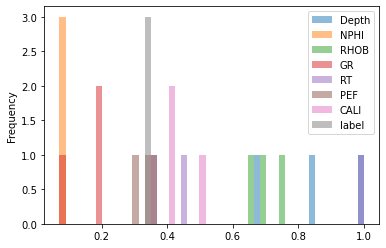

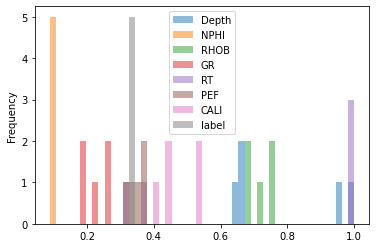

KeyboardInterrupt: 

In [16]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

def get_histo_1d(df_1d, x, bandwidth=0.05):
    """
    This method computes histogram of an panda Series using Kernel Density Estimation (kde)
    """
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(df_1d.values.reshape(-1, 1))

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(np.array(x).reshape(-1,1))
    
    return np.exp(logprob)

# extract from dataframe a serie (filter from one label, one feature )
## Your Code Here
df_RT_2 = df_all.groupby(['label','NPHI'])


stats = df_RT_2.describe()
print(stats)


# standard histogram plot provided by pandas
df_RT_2.plot.hist(bins=50, alpha=0.5)
plt.show()



x = np.linspace(stats['min'], stats['max'], 50)
hist = get_histo_1d(df_RT_2, x, bandwidth=0.03)

gaussian = norm(stats['mean'], stats['std'])
y = [ gaussian.pdf(v) for v in x ]

plt.plot(x, hist)
plt.plot(x, y)

At that point, you may select on pandas Serie that correspond to one feature in our normalized dataset for one class or for all classes gathered. 
Play cells :
* by selecting several distinct features
* by playing with bandwith parameter of get_histo_1d method

#### QQ plot ####

In statistics, a Q–Q (quantile-quantile) plot is a probability plot, which is a graphical method for comparing two probability distributions by plotting their quantiles against each other.

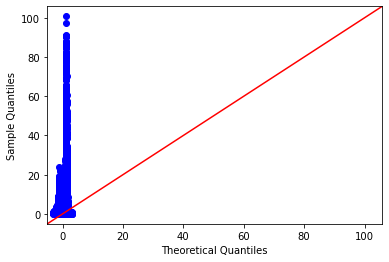

In [13]:
df_RT_2 = df_all.groupby(['label','NPHI']).sum()
df_RT_2
import statsmodels.api as sm
import pylab

sm.qqplot(df_RT_2, line='45')
pylab.show()


## 4. Use your favorite Classifier

**sklearn** comes with a collection of classifier that all use the same scheme for usage:
1. creates an instance of your classifier 
1. use **fit** method
1. then use your classifier to **predict** results on new data set

### 4.a Use Naive Bayes Classifier

Use **GaussianNB** classifier to fit your data on whole dataset. __hint__ : input variable **X** should be of shape (13930, 6) and output variable **Y** should be (13930,)

In [19]:
Y= df_all['NPHI'].values

Y.shape
Y
df_all.label

0        0
1        0
2        0
3        0
4        0
        ..
13925    2
13926    2
13927    2
13928    2
13929    2
Name: label, Length: 13930, dtype: int64

In [34]:
X = df_all[['CALI', 'Depth', 'GR', 'PEF', 'RHOB', 'RT']].values
X.shape


(13930, 6)

In [23]:
from sklearn.naive_bayes import GaussianNB

## Fit your data with a GaussianNB classifier called gnb
gnb = GaussianNB()
Y= df_all['label'].values
Y.shape[0]

X = df_all[['CALI', 'Depth', 'GR', 'PEF', 'RHOB', 'RT']].values
X.shape[1] 
gnb.fit(X,Y)
## Test your code is correct
expected_prior = np.array([0.21198851, 0.09102656, 0.69547739, 0.00150754])
compare = (expected_prior - gnb.class_prior_) < 1e-6
assert compare.all()
assert X.shape[1] == 6
assert Y.shape[0] == 13930

In [25]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Apply your classifier gnb to your input to construct **Y_predicted**. Then build the confusion matrix; __hint__ module sklearn.metrics

In [26]:
Y_predicted = gnb.predict(X)
Y_predicted 

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

Normalized confusion matrix


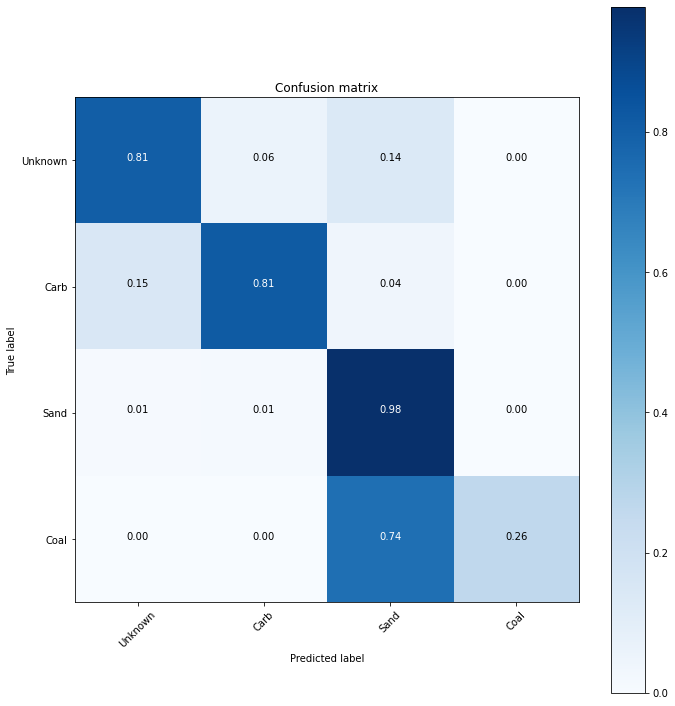

In [27]:
# create variable confusion as matrix of confusion
from sklearn.metrics import confusion_matrix
Y_predicted = gnb.predict(X)
confusion = confusion_matrix(Y_predicted, Y)

plot_confusion_matrix(confusion, classes=facies_cls, normalize = True)

Compute total_points (total of all points), good_points (total of points correctly classified), mislabeled_points (total of points wrongly classified) and then compute a performance (in %)

$$ 
performance = \frac{goodpoints}{totalpoints}
$$

In [28]:
len(Y) # 20039
len(Y_predicted)

13930

In [29]:
## Your Code Here
# compute total_points, mislabeled_points, and performance
total_points = len(Y)
good_point = Y_predicted.sum()
performance = total_points/good_point
mislabeled_points = Y_predicted.sum() - len(Y)
print(performance)

print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          total_points, mislabeled_points, performance    
))

0.6951444682868406
Number of mislabeled points out of a total 13930 points : 6109, performance 00.70%


### 4.b Use a Neural Network Classifier ###

This time we use a perceptron to fit our data. But such an algorithm may overfit your data when it learns. So before to fit, we need to split our data in two sets : 
1. (X_train, Y_train) for the training (let the classifier learn) 
1. (X_test, Y_test) to validate the training.

__hint__ : 
* use **MLPClassifier** from sklearn.neural_network module as classifier 
* use two hidden layers with 100, 16 nodes respectively and 500 iterations max.
* look at **train_test_split** method in **model_selection** module. 80% for train, 20% for test

#### Train/Test ####

In [34]:
# Create Train/Test sets
# create X_train, X_test, Y_train, Y_test 

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Y= df_all['label'].values
X = df_all[['CALI', 'Depth', 'GR', 'PEF', 'RHOB', 'RT']].values

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25,  random_state=1)

# Control that you have enough items for each class
df_train = pd.DataFrame(data=y_train, columns=['label'])
df_train.value_counts().sort_index()

label
0        2221
1         952
2        7258
3          16
dtype: int64

#### MLPClassifier ####

Training set score: 0.707380
Test set score: 0.713465


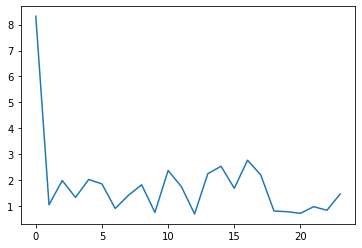

In [39]:
# fit Y_train = f(X_train) using MLPClassifier
## create mlp classifier

mlp= MLPClassifier(hidden_layer_sizes=(100,16), max_iter=500,random_state=1)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

#To show that the loss function decreases with iterations
plt.plot(mlp.loss_curve_)

#### Prediction

Use your trained mlp classifier to **predict** results on **X_test**. Then compute the confusion matrix for these **Y_test_predicted** with the sampled **Y_test**


Confusion matrix, without normalization


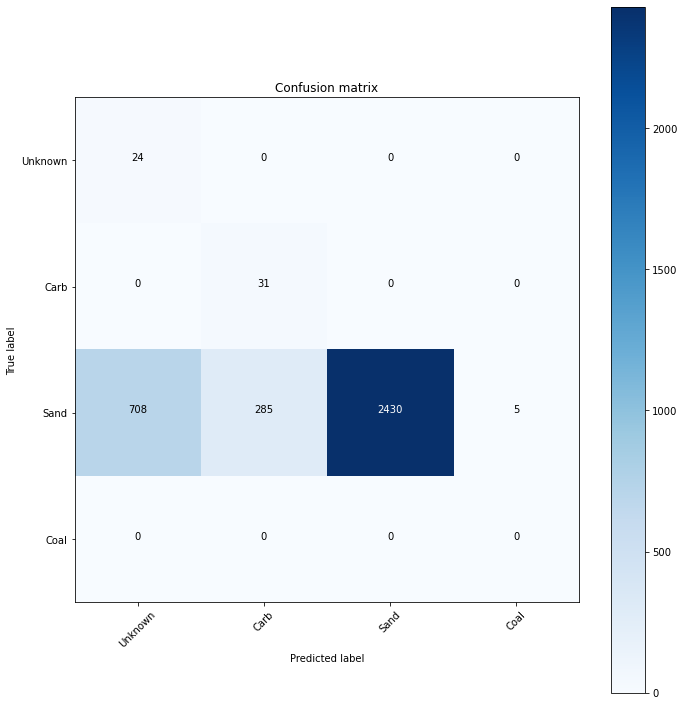

In [42]:
Y_test_predicted = mlp.predict(X_test)

confusion = confusion_matrix(Y_test_predicted,y_test)

plot_confusion_matrix(confusion, classes=facies_cls)

#### Performance ####
Then use the same performance computation as with NaiveBayes. Compare the computed performance with the mlp.score_ computed after learning step.

In [48]:
# create totalpoints, good_points

total_points = len(y_test)
good_points = Y_test_predicted.sum()
performance = total_points/good_point
mislabeled_points = Y_test_predicted.sum() - len(y_test)
print(performance)

print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          total_points, total_points-good_points,
          100*good_points/total_points
))

0.5057354435893713
Number of mislabeled points out of a total 3483 points : -3404, performance 197.73%


In this project we have only tested two specific classifiers, there exists plenty of other whose all have pros/cons and their own specificities (it means parameters to tune). 

Only with scikit, have a look at https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

Feel free to test other DecisionTreeClassifier, RandomForestClassifier, ... They all have the same API in scikit :-)